# How to execute this code

1. Code has been executed using the Jupyter Notebook
2. Make sure the below dependencies are installed. The dependencies are usually already installed for you if you are using Jupyter Notebook
3. Run the first 4 cells here to set up the core logic of the algorithm 
4. After that, scroll down to the bottom to the demo section to run the code for yourself.

In [27]:
import json
import csv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [28]:
file_path = 'instance_prices.csv'
df = pd.read_csv(file_path)

selected_columns = df[['API Name', 'vCPUs', 'Memory', 'Linux On Demand cost']]
selected_columns.head(20)

,API Name,vCPUs,Memory,Linux On Demand cost
0,m6a.24xlarge,96 vCPUs,384.0 GiB,$4.1472 hourly
1,m5dn.xlarge,4 vCPUs,16.0 GiB,$0.272 hourly
2,c6a.8xlarge,32 vCPUs,64.0 GiB,$1.224 hourly
3,g5.16xlarge,64 vCPUs,256.0 GiB,$4.096 hourly
4,r5ad.16xlarge,64 vCPUs,512.0 GiB,$4.192 hourly
5,m5a.2xlarge,8 vCPUs,32.0 GiB,$0.344 hourly
6,m5n.metal,96 vCPUs,384.0 GiB,$5.712 hourly
7,m5ad.2xlarge,8 vCPUs,32.0 GiB,$0.412 hourly
8,r5b.xlarge,4 vCPUs,32.0 GiB,$0.298 hourly
9,r5n.12xlarge,48 vCPUs,384.0 GiB,$3.576 hourly


In [29]:
EBS_types = {
        "io2": {
            "use_case": set(["mission-critical workloads", "databases", "high-performance apps"]),
            "price": 0.125,  # per GB/month
            "iops_price": 0.046,
            "size_range": (4, 64000),  # in GB
            "max_throughput": "1000 MB/s",
            "max_iops": 256000,
        },
        "io1": {
            "use_case": set(["mission-critical workloads", "databases", "high-performance apps"]),
            "price": 0.125,  # per GB/month
            "iops_price": 0.065,
            "size_range": (4, 64000),  # in GB
            "max_throughput": "1000 MB/s",
            "max_iops": 64000,
        },
        "gp3": {
            "use_case": set(["virtual desktops", "single instance databases", "hpc", "low-latency apps", "boot volumes", "dev"]),
            "price": 0.08,  # per GB/month
            "size_range": (1, 16000),  # in GB
            "max_throughput": "1000 MB/s",
            "max_iops": 16000,
        },
        "gp2": {
            "use_case": set(["general", "low-latency apps", "boot volumes", "dev"]),
            "price": 0.10,  # per GB/month
            "size_range": (1, 16000),  # in GB
            "max_throughput": "250 MB/s",
            "max_iops": 16000,
        },
        "st1": {
            "use_case": set(["big data", "data warehouses", "log processing"]),
            "price": 0.045,  # per GB/month
            "size_range": (125, 16000),  # in GB
            "max_throughput": "500 MB/s",
            "max_iops": 500,
        },
        "sc1": {
            "use_case": set(["cold data storage", "infrequent access"]),
            "price": 0.025,  # per GB/month
            "size_range": (500, 16000),  # in GB
            "max_throughput": "250 MB/s",
            "max_iops": 250,
        }
    }

In [30]:
def find_instance_type(task_type):
    general_tasks = [
        "server", "development", "containers", "batch processing", 
        "web hosting", "ci/cd pipelines", "small databases", 
        "file storage", "devops tools"
    ]

    memory_tasks = [
        "database", "big data", "genomics", "in-memory databases", 
        "data warehousing", "memory analytics", 
        "genome sequencing", "caching services"
    ]

    compute_tasks = [
        "hpc", "machine learning", "ai", "ml", 
        "video rendering", "scientific simulations", 
        "financial modeling", "blockchain mining", 
        "ai training"
    ]


    if task_type in general_tasks:
        return "general"
    elif task_type in memory_tasks:
        return "memory"
    elif task_type in compute_tasks:
        return "compute"

    return "general"


def convert_workload_to_specs(base_specs, instance_type, workload):
    if workload == "Light":
        upper_bound = "Medium"
    elif workload == "Medium":
        upper_bound = "Heavy"
    elif workload == "Heavy":
        upper_bound = "Very Heavy"
    else:
        upper_bound = None

    base_vcpus, base_ram = base_specs[instance_type][workload]
    if upper_bound:
        upper_vcpus, upper_ram = base_specs[instance_type][upper_bound]
        return base_vcpus, base_ram, upper_vcpus, upper_ram
    
    return base_vcpus, base_ram, 999, 9999


def get_user_params():
    region = input("Enter the region you wish to host your instance: ")

    task_type = input("What will the instance be used for: ").lower()
    instance_type = find_instance_type(task_type.lower())

    workload = input("Enter the Expected Workload (e.g., Light, Medium, Heavy, Very Heavy): ")

    hours = float(input("Enter the number of hours the instance will run in a week: ")) * 4
    budget = float(input("Enter your monthly budget for instances: $"))

    return region, task_type, instance_type, workload, hours, budget


def fetch_instance_pricing():
    instance_prices = []
    with open('instance_prices.csv', 'r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            try:
                instance_prices.append({
                    'instance_type': row['API Name'],
                    'vcpu': int(row['vCPUs'].split()[0]),
                    'memory': float(row['Memory'].split()[0]),
                    'price_per_hour': float(row['Linux On Demand cost'][1:].split()[0])
                })
            except ValueError:
                continue

    return instance_prices


def filter_optimal_instances(instance_prices, base_vcpus, base_ram, upper_vcpus, upper_ram, hours, budget):
    filtered_instances = [
        instance for instance in instance_prices
        if instance['vcpu'] >= base_vcpus and instance['vcpu'] < upper_vcpus and instance['memory'] >= base_ram and instance['memory'] < upper_ram
    ]

    optimal_instances = []
    for instance in filtered_instances:
        total_cost = instance['price_per_hour'] * hours
        if total_cost <= budget:
            # Geometric mean of vCPU, Memory, and Cost Performance
            vcpu_weight = 0.5
            memory_weight = 0.3
            cost_weight = 0.2
            performance_score = (instance['vcpu'] ** vcpu_weight) * (instance['memory'] ** memory_weight) * ((budget - total_cost) ** cost_weight)

            # Harmonic mean to prioritize lower cost while keeping performance balanced
            harmonic_performance = 3 / ((1 / instance['vcpu']) + (1 / instance['memory']) + (1 / (budget - total_cost)))
            
            # Exponential decay for instances close to upper budget limit (penalizes costlier instances)
            penalty_factor = (budget - total_cost) / budget  # ranges from 0 to 1
            performance_to_cost_with_penalty = (instance['vcpu'] * instance['memory']) * penalty_factor ** 2

            # Weighted cost-effectiveness with diminishing returns as instance size increases
            diminishing_return_factor = 1 / (1 + (instance['vcpu'] / 16) + (instance['memory'] / 64))
            cost_effectiveness = (instance['vcpu'] * instance['memory'] * diminishing_return_factor) / total_cost

            # Logistic growth for performance improvement, more value for initial performance boost
            logistic_growth = (1 / (1 + 2.718 ** (-0.1 * (instance['vcpu'] + instance['memory'])))) / total_cost

            instance['cost_performance_ratio'] = (0.3 * performance_score + 0.2 * harmonic_performance + 0.2 * performance_to_cost_with_penalty + 0.2 * cost_effectiveness + 0.1 * logistic_growth) / 1
            optimal_instances.append(instance)

    # Sort instances by cost-performance ratio (higher is better)
    optimal_instances.sort(key=lambda x: x['cost_performance_ratio'], reverse=True)

    return optimal_instances


def get_ebs_user_input():
    size = int(input("Enter the required size of the volume (GB): "))
    budget = float(input("Enter your monthly budget for storage: $"))

    return size, budget


def check_iops_requirement():
    high_iops_flag = input("Does your workload require very high IOPS (Y/N)? ").strip().lower()

    if high_iops_flag == "y":
        estimated_iops = int(input("Please provide an estimate of the required IOPS: "))
        # Recommend io2 if estimated IOPS is very high, otherwise recommend io1
        if estimated_iops > 64000:
            return "io2", estimated_iops
        elif estimated_iops <= 64000 and estimated_iops > 16000:
            return "io1", estimated_iops
        
    return None, None


def recommend_ebs(user_use_case, required_size, budget):
    iops_specific_volume, estimated_iops = check_iops_requirement()

    suitable_ebs = []
    if iops_specific_volume:
        ebs_info = EBS_types[iops_specific_volume]
        total_cost = (ebs_info['price'] * required_size) + (ebs_info['iops_price'] * estimated_iops)

        if total_cost > budget:
            print("No EBS volume within budget!")
            return

        # Append the IOPS-specific volume to suitable_ebs
        suitable_ebs.append({
            'type': iops_specific_volume,
            'price_per_gb': ebs_info['price'],
            'total_cost': total_cost,
            'max_throughput': ebs_info['max_throughput'],
            'max_iops': ebs_info['max_iops']
        })

    else:
        for ebs_type, details in EBS_types.items():
            if user_use_case in details['use_case']:
                min_size, max_size = details['size_range']

                if min_size <= required_size <= max_size:
                    if (details['price'] * required_size) <= budget:
                        suitable_ebs.append({
                            'type': ebs_type,
                            'price_per_gb': details['price'],
                            'total_cost': details['price'] * required_size,
                            'max_throughput': details['max_throughput'],
                            'max_iops': details['max_iops']
                        })

    # Sort by total cost
    suitable_ebs.sort(key=lambda x: x['total_cost'])

    # Return suitable_ebs or None if the list is empty
    return suitable_ebs if suitable_ebs else None

## Result 1

### **Parameters:**

**Region:** USA\
**Task Type:** Development\
**Workload:** Heavy\
**Hours/Month:** 150\
**Monthly Budget for Instances (\$):** 4500\
**Volume Size (GB):** 4096\
**Monthly Budget for Volumes (\$):** 500

In [18]:
if __name__ == "__main__":
    # Base specifications per instance type and workload
    base_specs = {
        "general": {"Light": (1, 2), "Medium": (8, 16), "Heavy": (16, 32), "Very Heavy": (32, 64)},
        "memory": {"Light": (2, 16), "Medium": (8, 64), "Heavy": (24, 192), "Very Heavy": (48, 384)},
        "compute": {"Light": (4, 8), "Medium": (16, 32), "Heavy": (32, 64), "Very Heavy": (96, 192)}
    }

    green_data_centers = {
        "USA": ["us-east-1", "us-gov-east-1", "us-east-2", "us-west-2", "us-gov-west-1", "us-west-1"],
        "Canada": ["ca-central-1", "ca-west-1"],
        "Europe": [
            "eu-west-1", "eu-central-1", "eu-west-2", "eu-south-1", "eu-west-3", "eu-north-1", 
            "eu-south-2", "eu-central-2"
        ],
        "Asia-Pacific": ["ap-south-1", "ap-south-2", "ap-northeast-3", "ap-northeast-1"],
        "China": ["cn-north-1", "cn-northwest-1"]
    }


#     region, task_type, instance_type, workload, hours, budget = get_user_params()
    region, task_type, instance_type, workload, hours, budget = "USA", "dev", "general", "Heavy", 150, 4500
    
    size, budget = get_ebs_user_input()
    recommendations = recommend_ebs(task_type, size, budget)

    if recommendations:
        ebs_details = [
            {
                "EBS Type": rec['type'],
                "Price/GB ($)": rec['price_per_gb'],
                "Total Cost ($)": rec['total_cost'],
                "Max Throughput (MB/s)": rec['max_throughput'],
                "Max IOPS": rec['max_iops']
            }
            for rec in recommendations
        ]

        ebs_df = pd.DataFrame(ebs_details)
    else:
        print("No EBS volume within budget!")

    base_vcpu, base_ram, upper_vcpu, upper_ram = convert_workload_to_specs(base_specs, instance_type, workload)
    instance_prices = fetch_instance_pricing()
    optimal_instances = filter_optimal_instances(instance_prices, base_vcpu, base_ram, upper_vcpu, upper_ram, hours, budget)
    
    instances_df = None
    if optimal_instances:
        instance_details = [
            {
                "Instance Type": instance['instance_type'],
                "vCPUs": instance['vcpu'],
                "Memory (GB)": instance['memory'],
                "Price/Hour ($)": instance['price_per_hour'],
                "Total Bill Per Month ($)": instance['price_per_hour'] * hours,
                "Cost-Performance Score": instance['cost_performance_ratio']
            }
            for instance in optimal_instances[:10]
        ]

        # Convert the list of dictionaries into a pandas DataFrame
        instances_df = pd.DataFrame(instance_details)
        
        if region in set(green_data_centers.keys()):
            print(f"\nGood news! There are green AWS data centers available near your region ({region}). Choose any of these data centers to be green in your energy usage:\n{green_data_centers[region]}\n")
        else:
            print("There are no green AWS data centers available near your region unfortunately.\n\n")
    else:
        print("No instances found that meet your requirements and budget.")

Enter the required size of the volume (GB): 4096
Enter your monthly budget for storage: $500
Does your workload require very high IOPS (Y/N)? n

Good news! There are green AWS data centers available near your region (USA). Choose any of these data centers to be green in your energy usage:
['us-east-1', 'us-gov-east-1', 'us-east-2', 'us-west-2', 'us-gov-west-1', 'us-west-1']



In [19]:
ebs_df

,EBS Type,Price/GB ($),Total Cost ($),Max Throughput (MB/s),Max IOPS
0,gp3,0.08,327.68,1000 MB/s,16000
1,gp2,0.10,409.60,250 MB/s,16000


In [10]:
instances_df

,Instance Type,vCPUs,Memory (GB),Price/Hour ($),Total Bill Per Month ($),Cost-Performance Score
0,inf1.6xlarge,24,48.0,1.1800,177.00,120.606294
1,vt1.6xlarge,24,48.0,1.3000,195.00,109.956099
2,a1.metal,16,32.0,0.4080,61.20,97.245497
3,a1.4xlarge,16,32.0,0.4080,61.20,97.245497
4,c5n.4xlarge,16,42.0,0.8640,129.60,92.908313
5,c6g.4xlarge,16,32.0,0.5440,81.60,89.799331
6,c6a.4xlarge,16,32.0,0.6120,91.80,86.230186
7,c6gd.4xlarge,16,32.0,0.6144,92.16,86.105975
8,c5a.4xlarge,16,32.0,0.6160,92.40,86.023234
9,c5.4xlarge,16,32.0,0.6800,102.00,82.756130


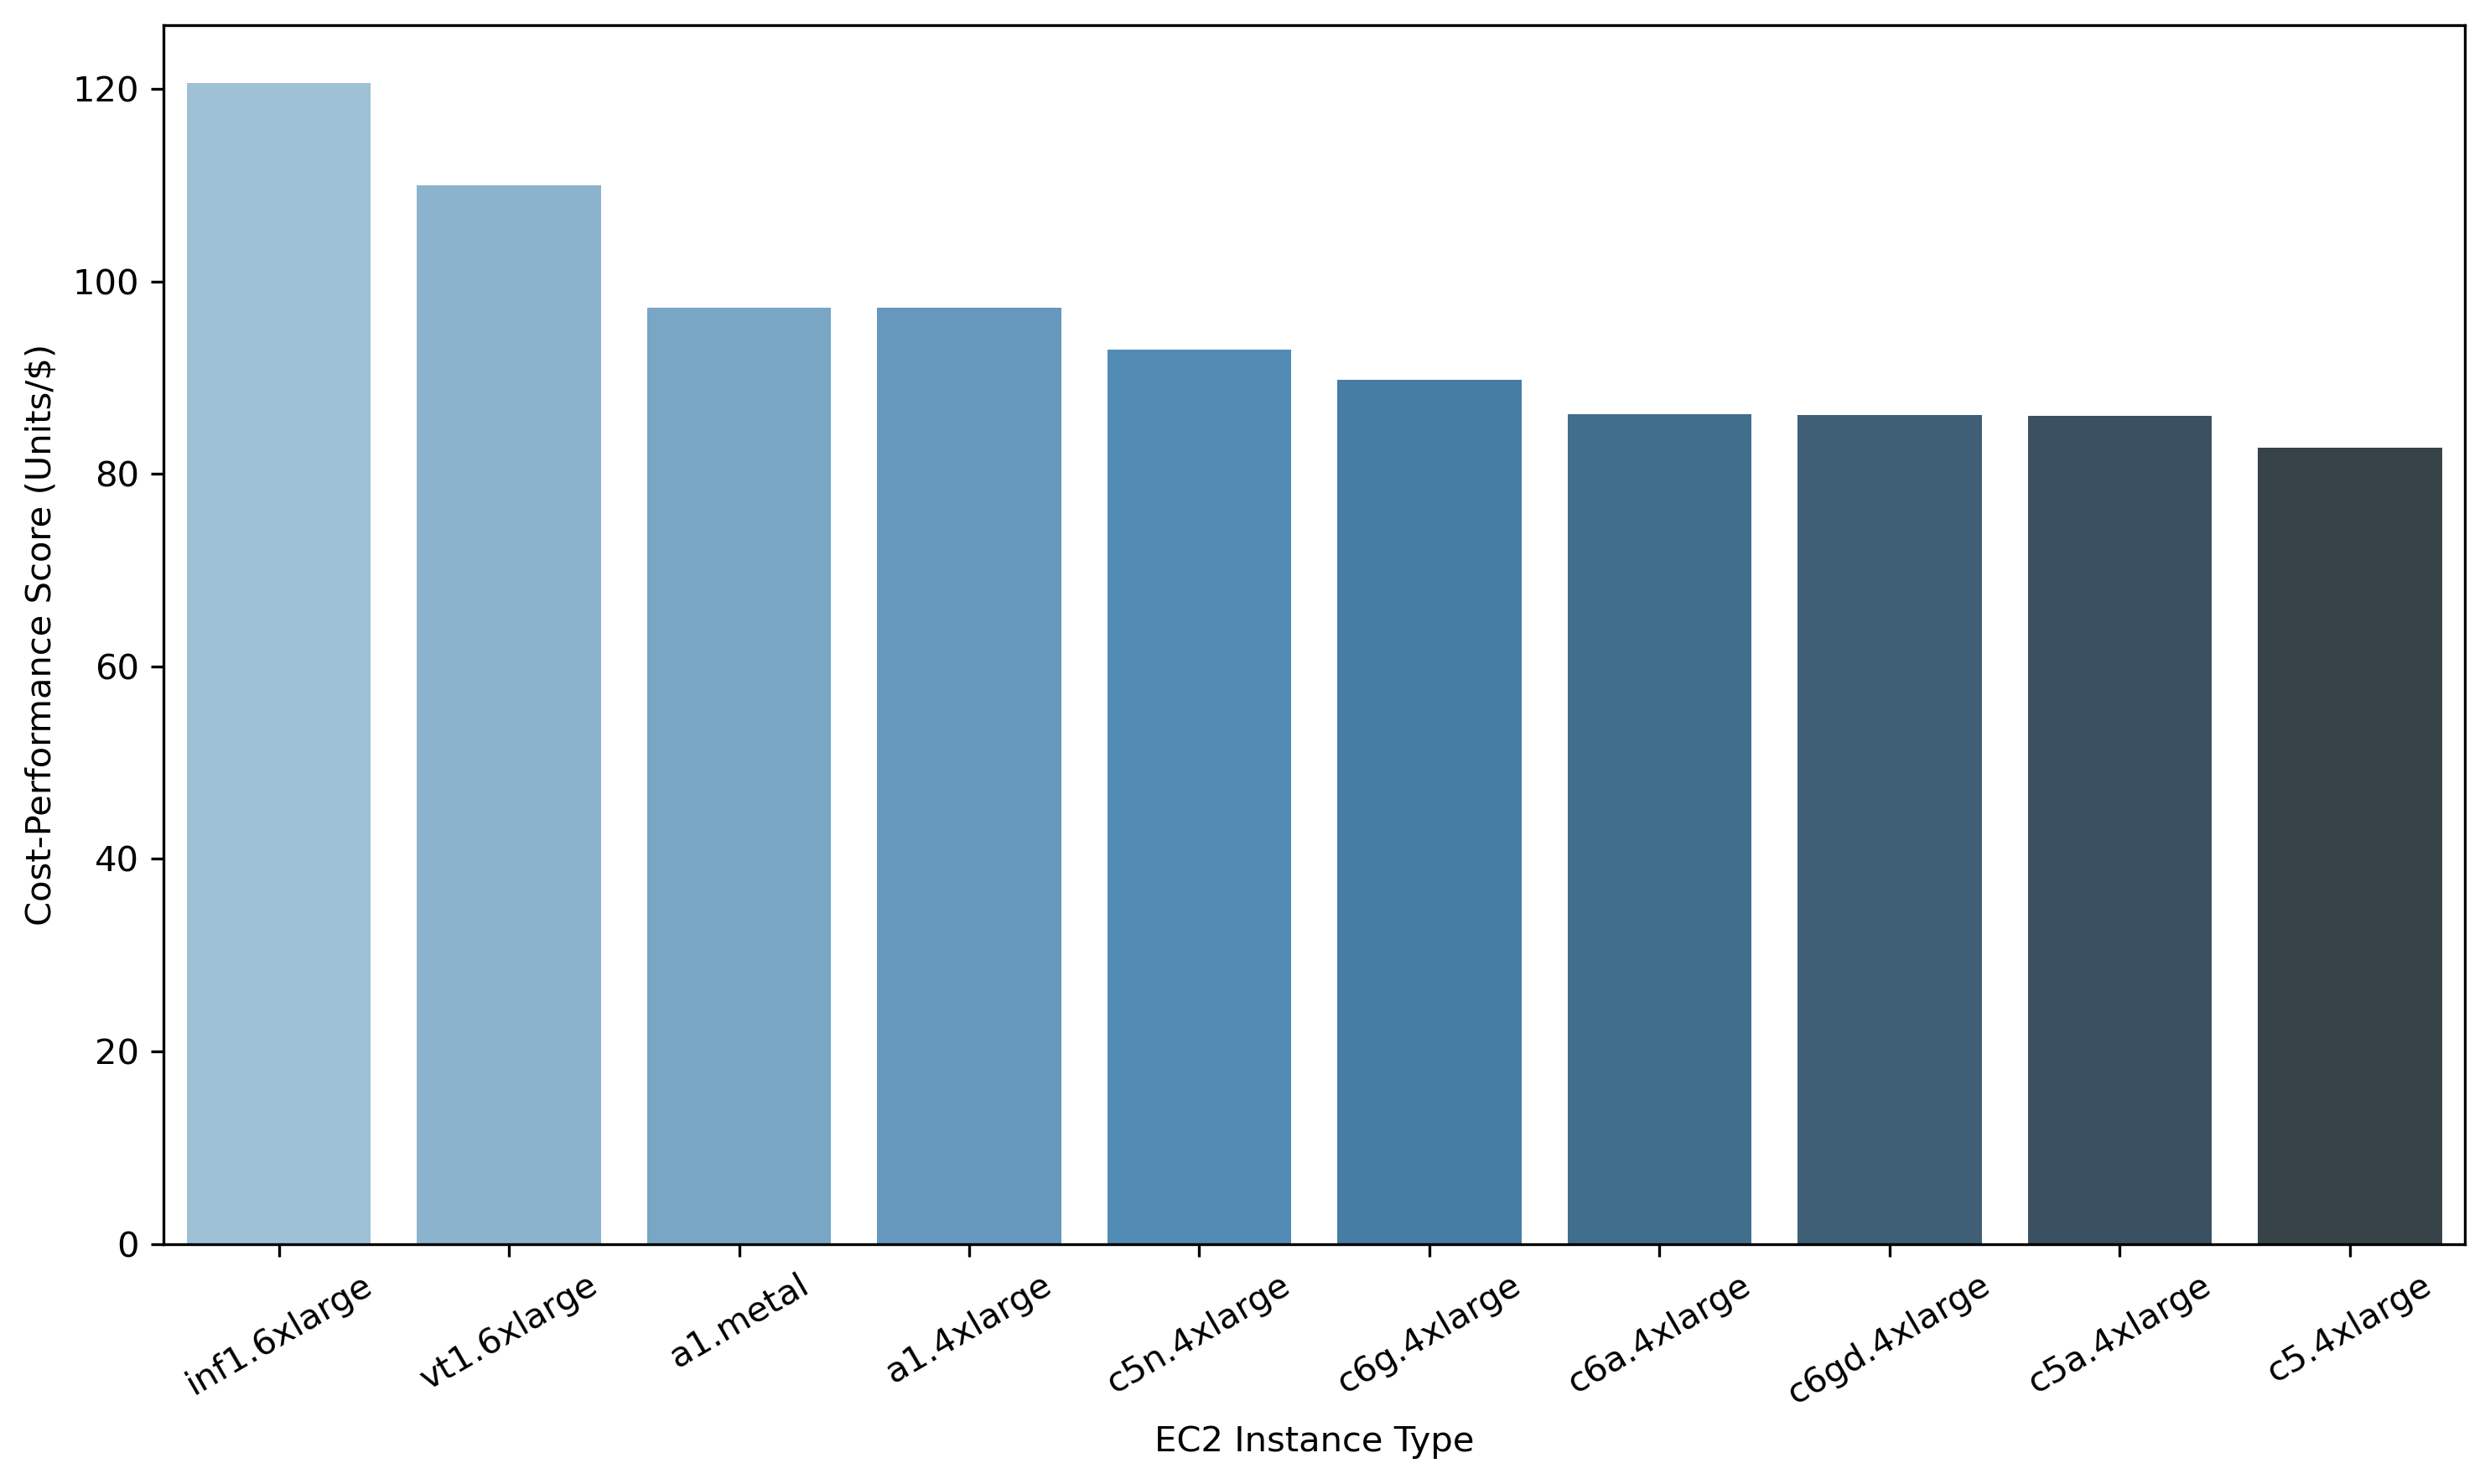

In [11]:
plt.figure(figsize=(10, 6), dpi=300)
sns.barplot(data=instances_df, x='Instance Type', y='Cost-Performance Score', palette='Blues_d')

plt.xlabel('EC2 Instance Type')
plt.ylabel('Cost-Performance Score (Units/$)')
plt.xticks(rotation=30)
plt.tight_layout()
# plt.savefig("cost-performance.tiff", dpi=300, bbox_inches='tight')
plt.show()

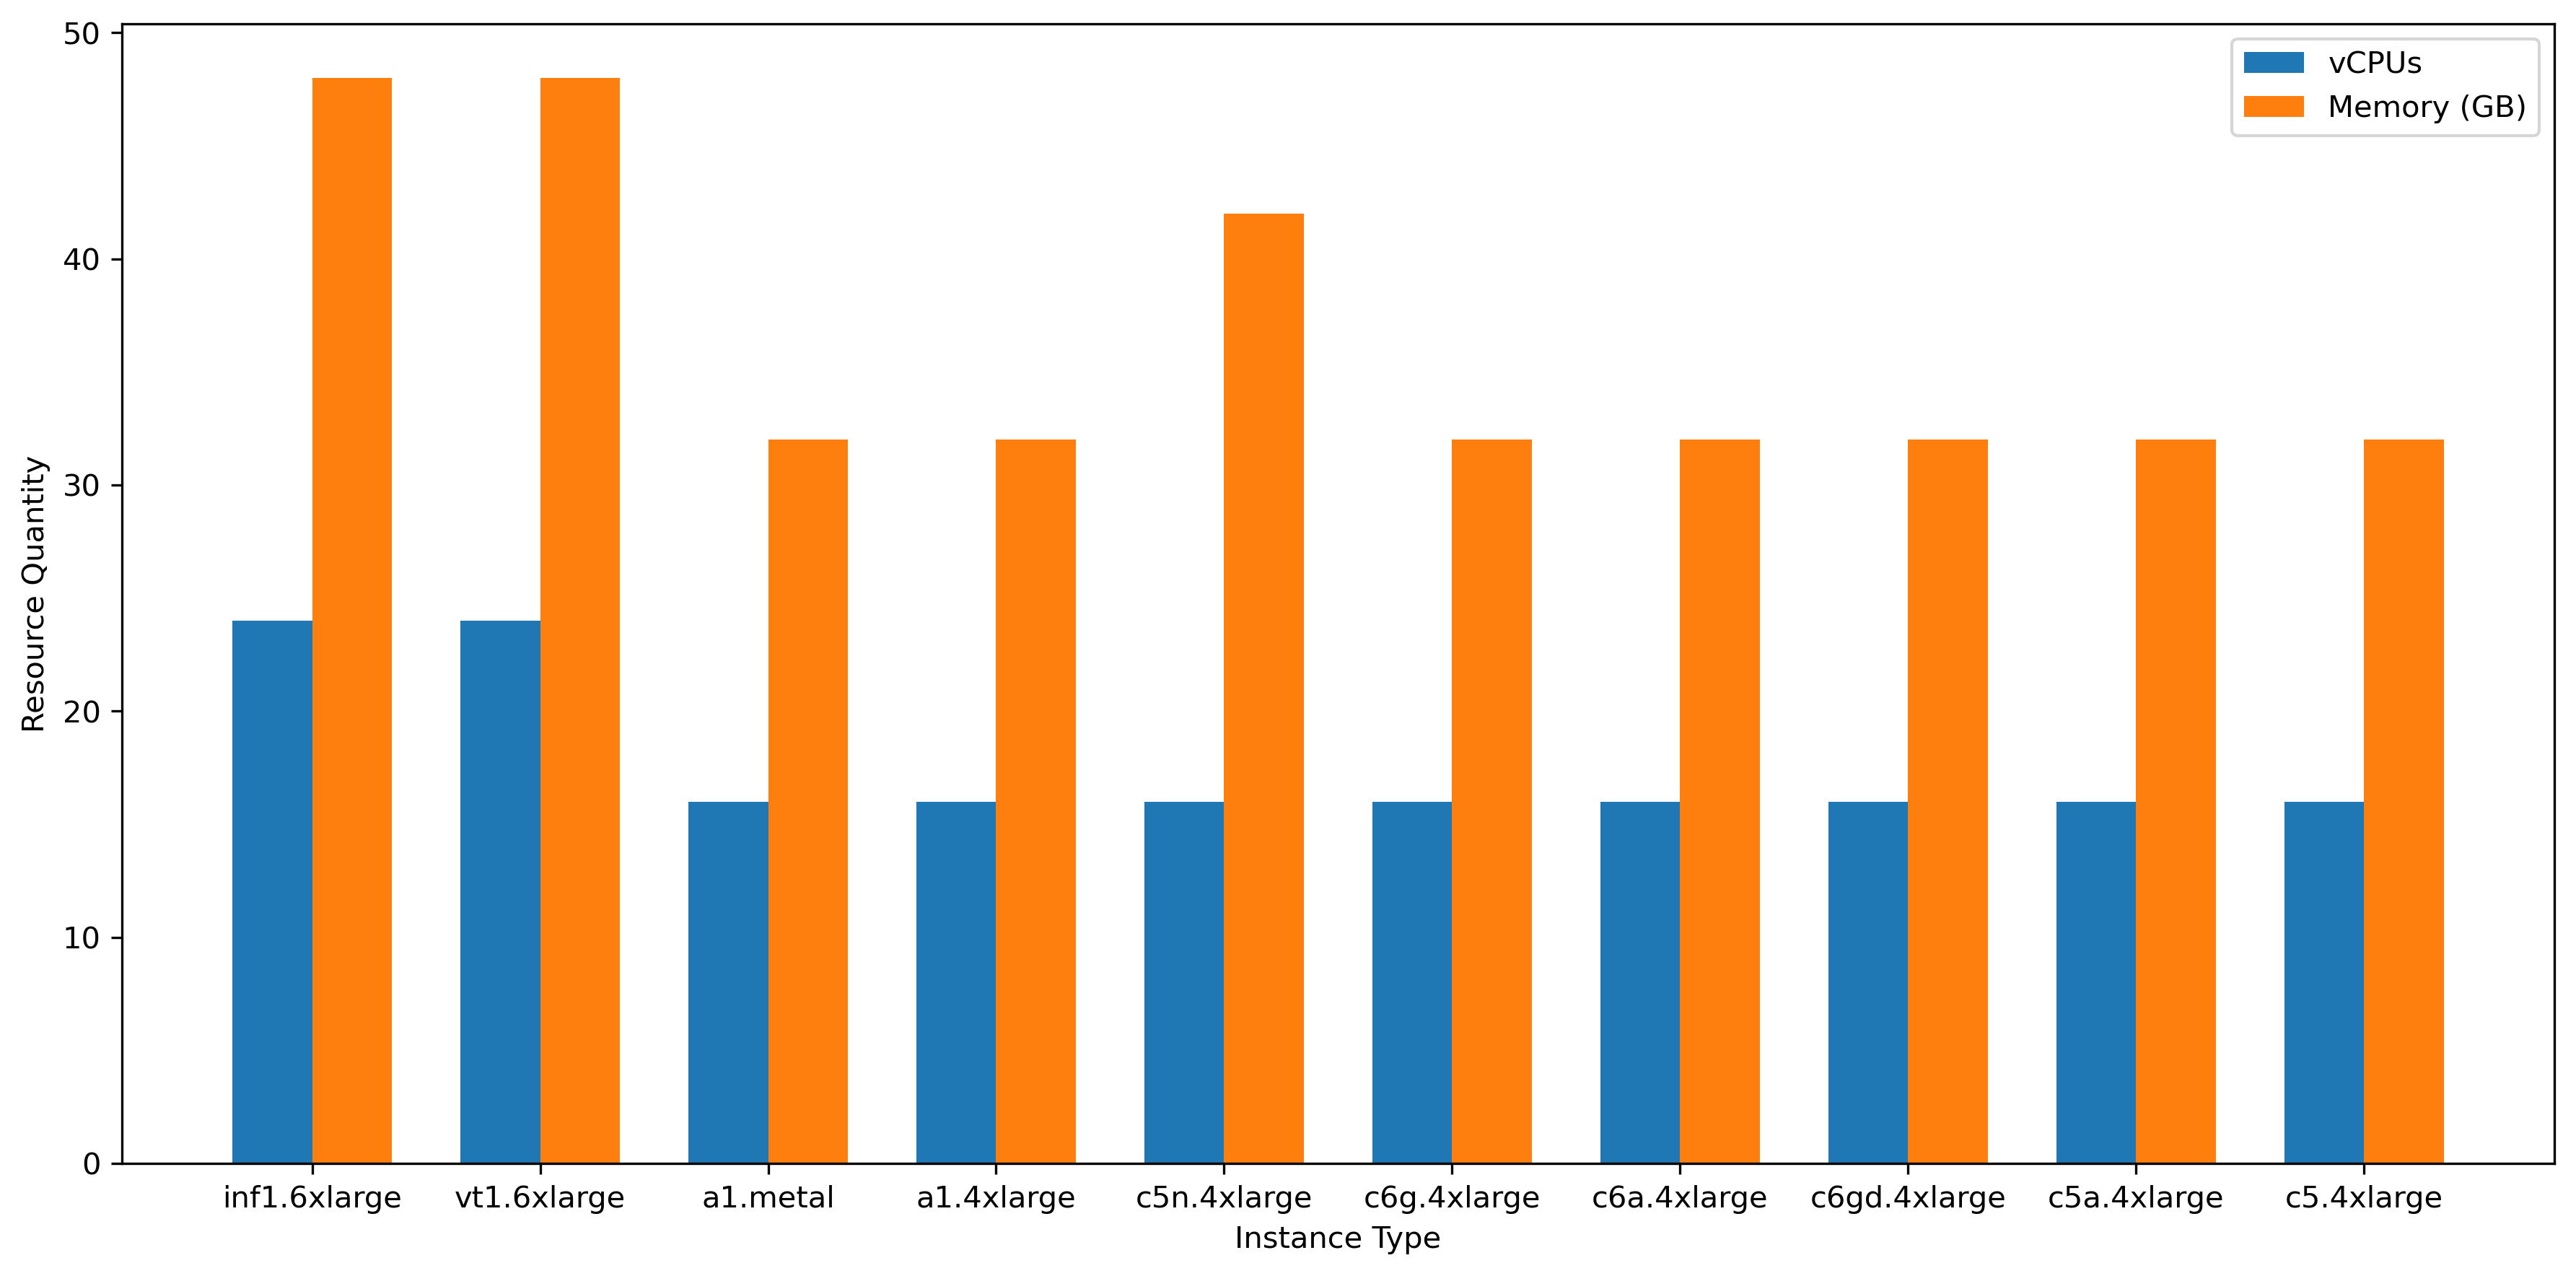

In [12]:
bar_width = 0.35

index = np.arange(len(instances_df))
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)
vcpu_bars = ax.bar(index, instances_df['vCPUs'], bar_width, label='vCPUs')
memory_bars = ax.bar(index + bar_width, instances_df['Memory (GB)'], bar_width, label='Memory (GB)')

ax.set_xlabel('Instance Type')
ax.set_ylabel('Resource Quantity')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(instances_df['Instance Type'])
ax.legend()

plt.tight_layout()
# plt.savefig("vcpu_memory.tiff", dpi=300, bbox_inches='tight')
plt.show()

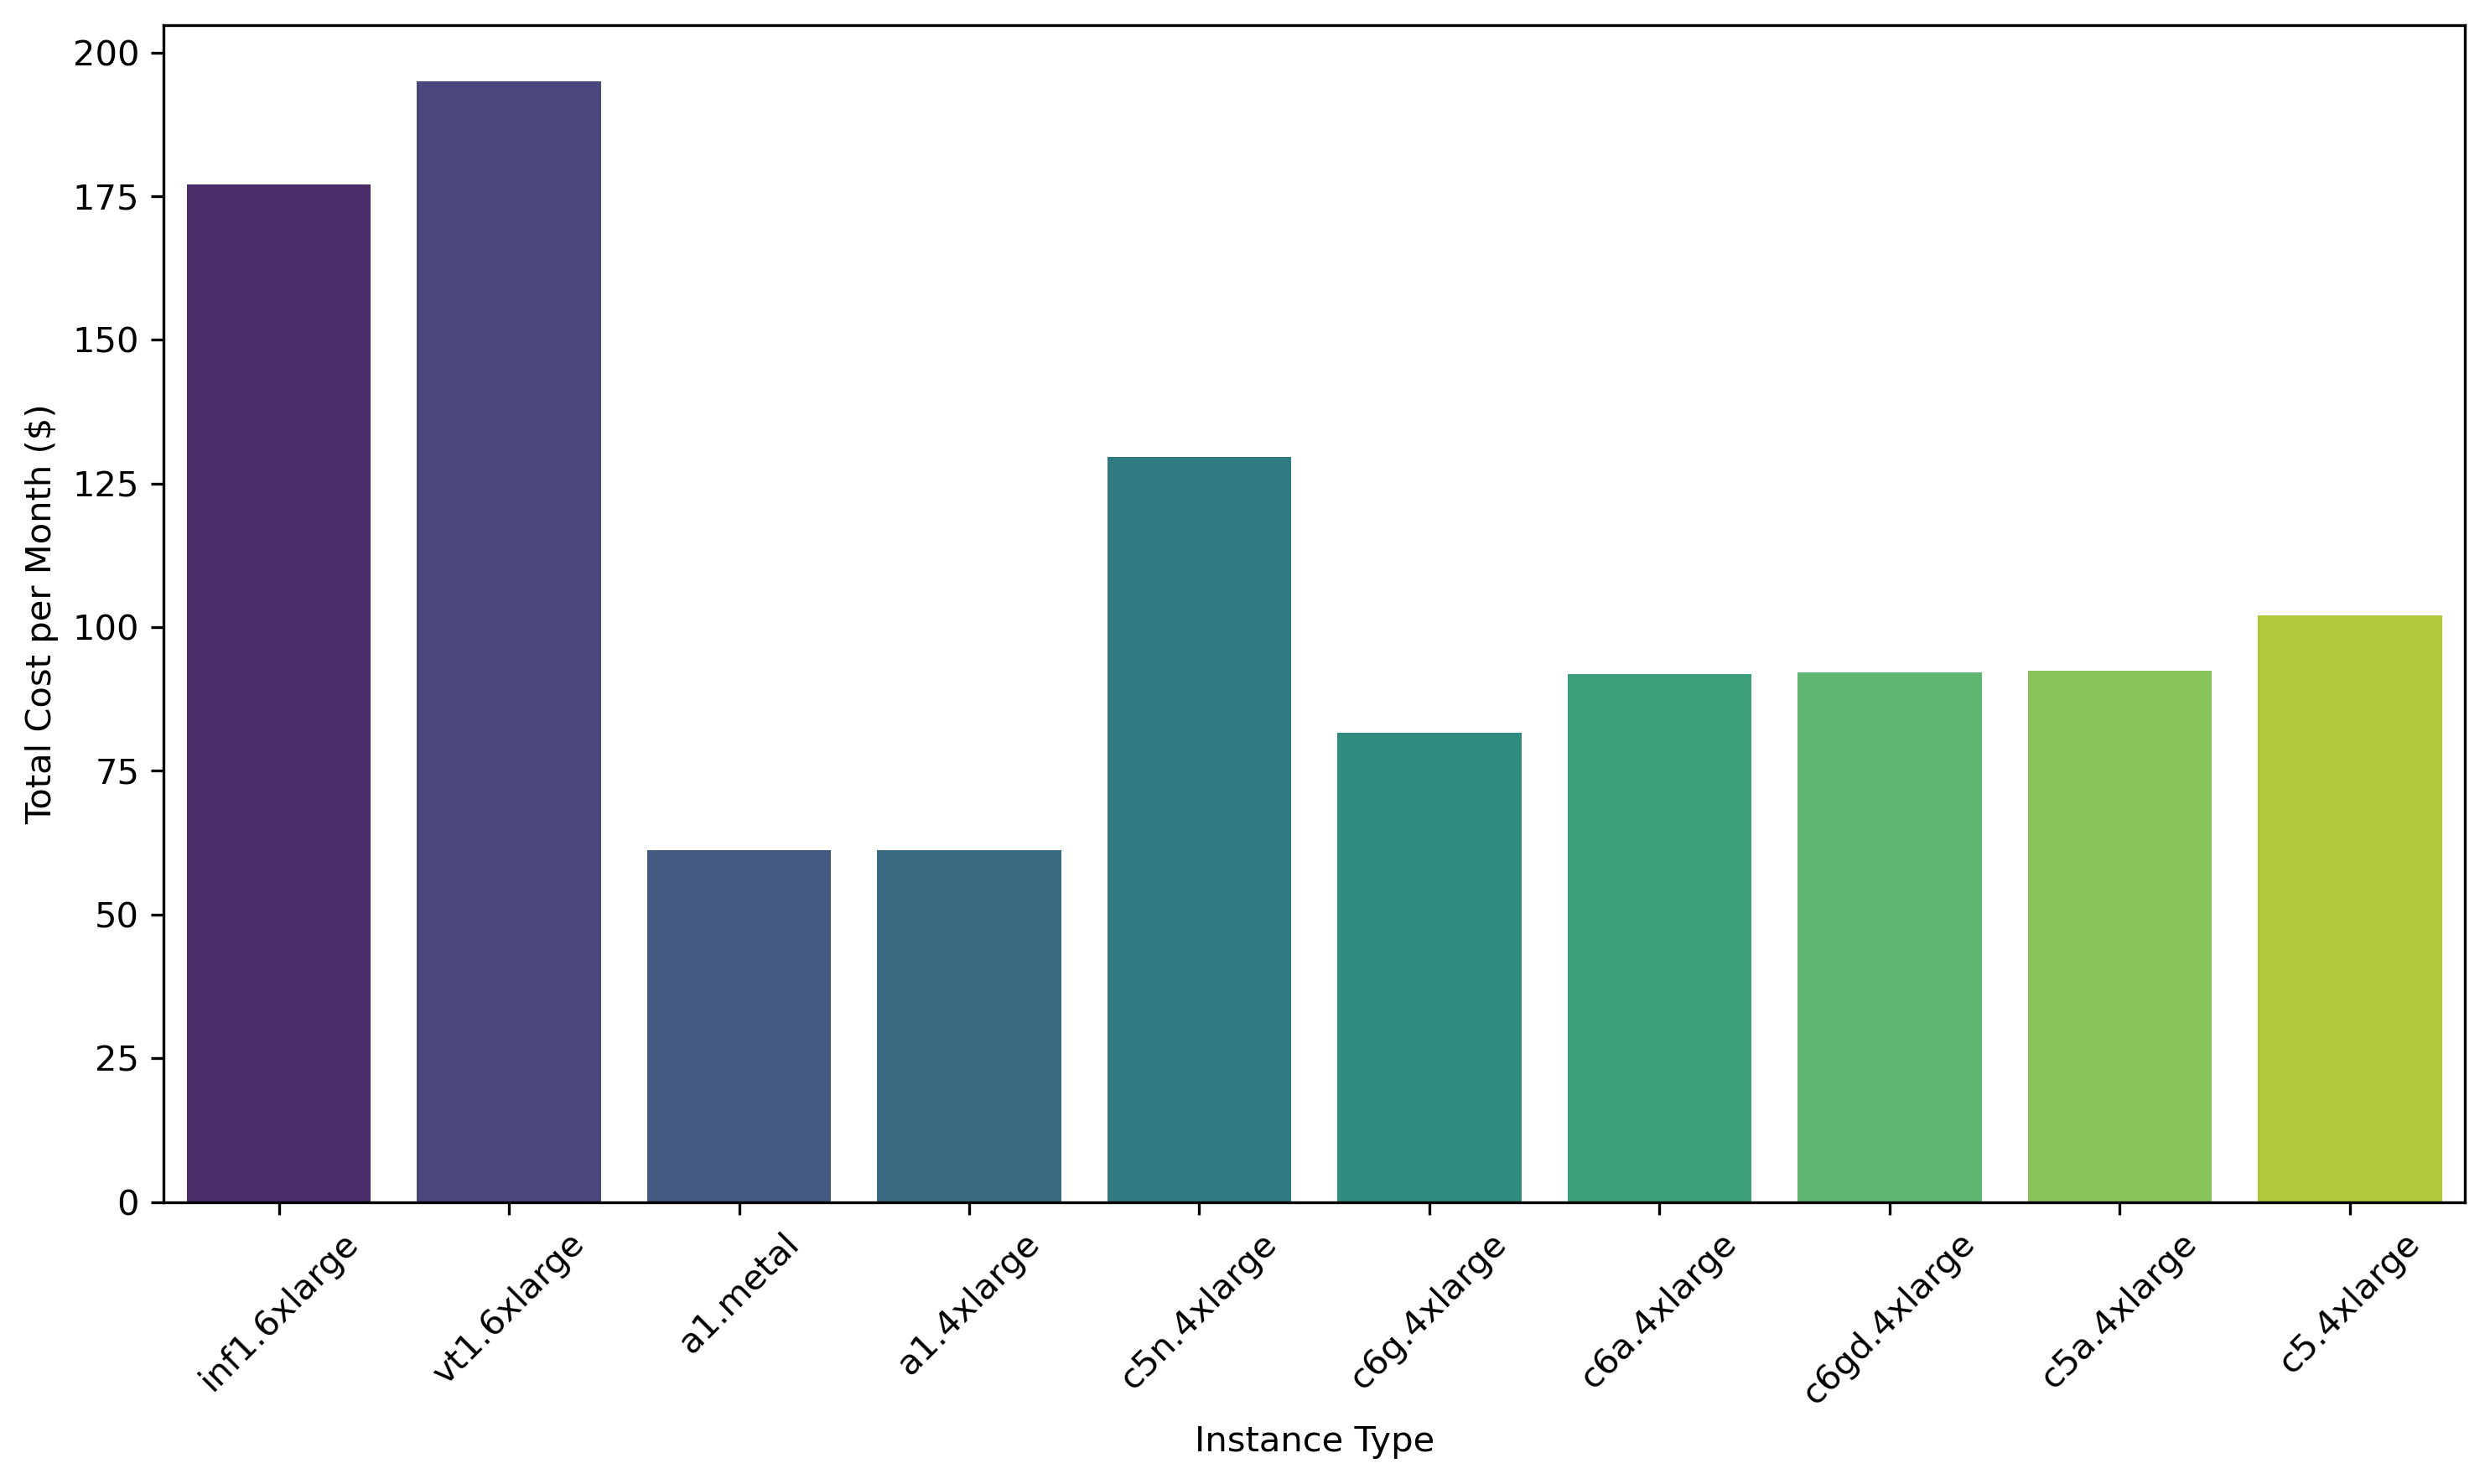

In [13]:
plt.figure(figsize=(10, 6), dpi=300)
sns.barplot(data=instances_df, x='Instance Type', y='Total Bill Per Month ($)', palette='viridis')

plt.xlabel('Instance Type')
plt.ylabel('Total Cost per Month ($)')
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig("total_cost.tiff", dpi=300, bbox_inches='tight')
plt.show()

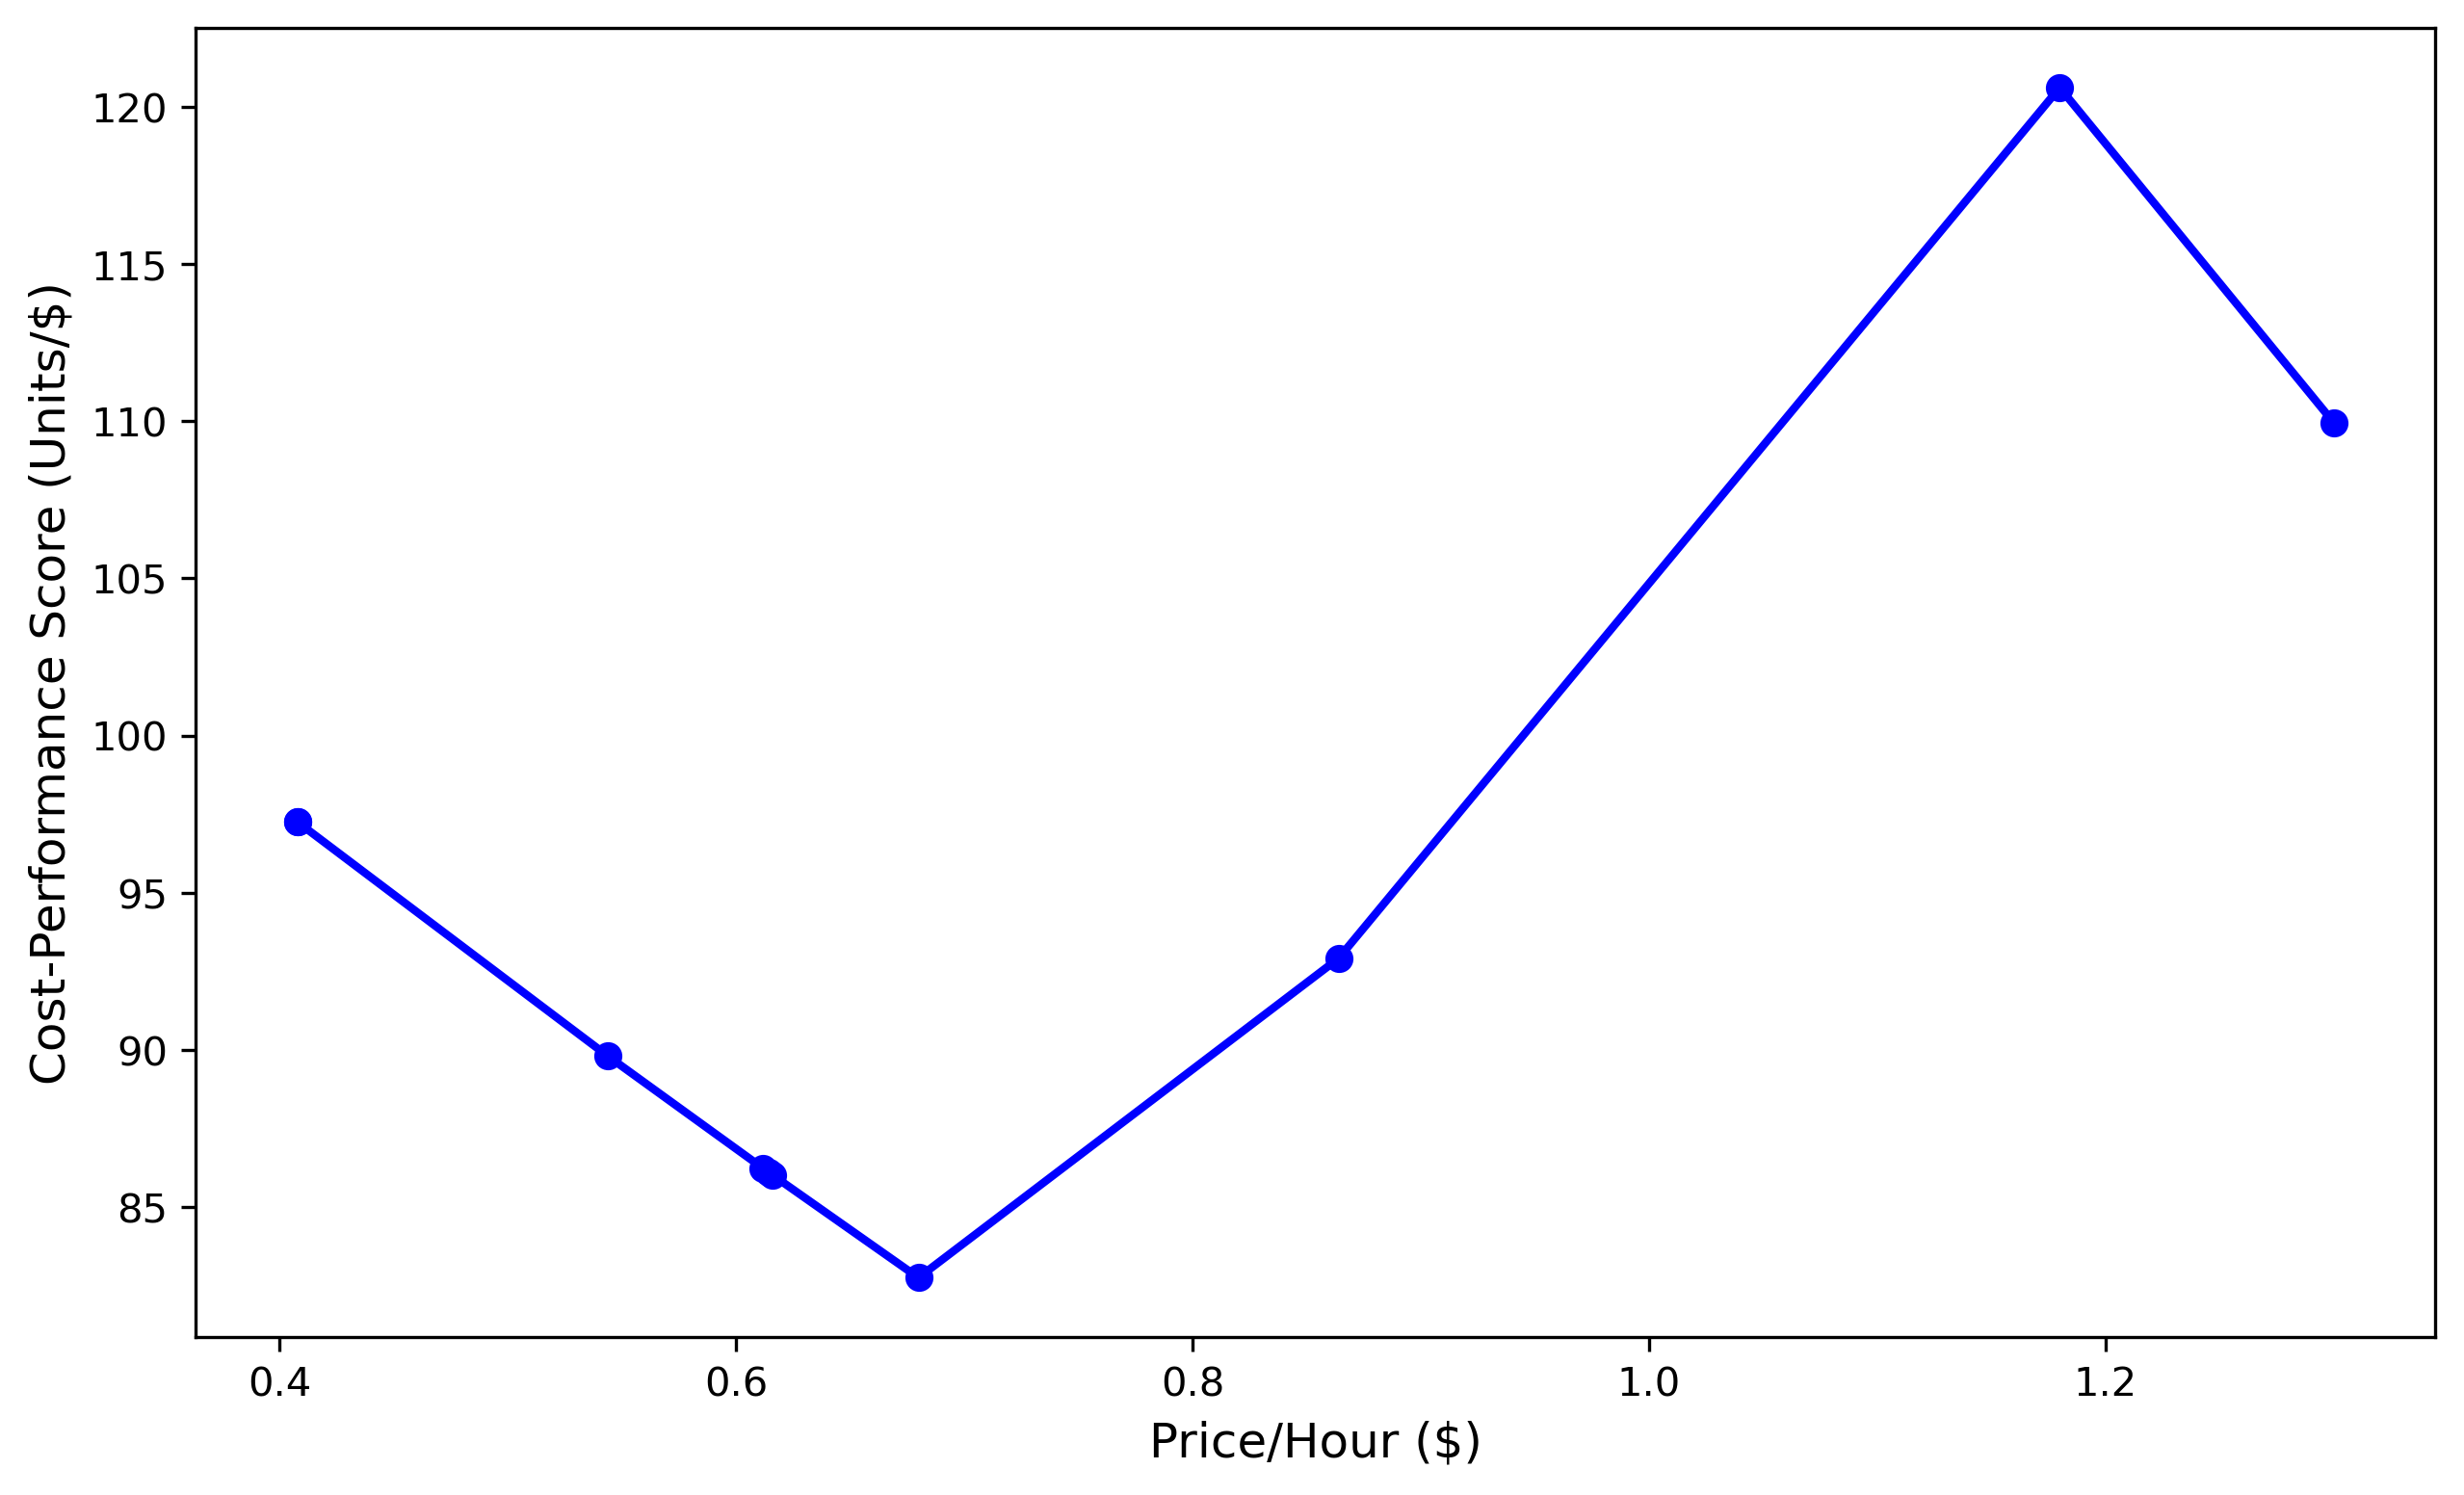

In [14]:
instances_df_sorted = instances_df.sort_values(by="Price/Hour ($)")

# Create a line plot for Cost vs. Performance
plt.figure(figsize=(10, 6), dpi=300)  # High resolution
plt.plot(instances_df_sorted["Price/Hour ($)"], instances_df_sorted["Cost-Performance Score"], color="b", marker="o", linestyle='-', linewidth=2)

# Adding labels and title
plt.xlabel("Price/Hour ($)", fontsize=12)
plt.ylabel("Cost-Performance Score (Units/$)", fontsize=12)


# Save the figure
# plt.savefig("cost_vs_performance_trend.tiff", dpi=300, bbox_inches='tight')
plt.show()

## Result 2

### **Parameters:**

**Region:** Europe\
**Task Type:** Database Server\
**Workload:** Very Heavy\
**Hours/Month:** 670\
**Monthly Budget for Instances (\$):** 18000\
**Volume Size (GB):** 10000\
**Monthly Budget for Volumes (\$):** 20000

In [15]:
if __name__ == "__main__":
    # Base specifications per instance type and workload
    base_specs = {
        "general": {"Light": (1, 2), "Medium": (8, 16), "Heavy": (16, 32), "Very Heavy": (32, 64)},
        "memory": {"Light": (2, 16), "Medium": (8, 64), "Heavy": (24, 192), "Very Heavy": (48, 384)},
        "compute": {"Light": (4, 8), "Medium": (16, 32), "Heavy": (32, 64), "Very Heavy": (96, 192)}
    }

    green_data_centers = {
        "USA": ["us-east-1", "us-gov-east-1", "us-east-2", "us-west-2", "us-gov-west-1", "us-west-1"],
        "Canada": ["ca-central-1", "ca-west-1"],
        "Europe": [
            "eu-west-1", "eu-central-1", "eu-west-2", "eu-south-1", "eu-west-3", "eu-north-1", 
            "eu-south-2", "eu-central-2"
        ],
        "Asia-Pacific": ["ap-south-1", "ap-south-2", "ap-northeast-3", "ap-northeast-1"],
        "China": ["cn-north-1", "cn-northwest-1"]
    }


    # region, task_type, instance_type, workload, hours, budget = get_user_params()
    region, task_type, instance_type, workload, hours, budget = "Europe", "database", "memory", "Very Heavy", 670, 18000
    
    size, budget = get_ebs_user_input()
    recommendations = recommend_ebs(task_type, size, budget)

    if recommendations:
        ebs_details = [
            {
                "EBS Type": rec['type'],
                "Price/GB ($)": rec['price_per_gb'],
                "Total Cost ($)": rec['total_cost'],
                "Max Throughput (MB/s)": rec['max_throughput'],
                "Max IOPS": rec['max_iops']
            }
            for rec in recommendations
        ]

        ebs_df = pd.DataFrame(ebs_details)
    else:
        print("No EBS volume within budget!")

    base_vcpu, base_ram, upper_vcpu, upper_ram = convert_workload_to_specs(base_specs, instance_type, workload)
    instance_prices = fetch_instance_pricing()
    optimal_instances = filter_optimal_instances(instance_prices, base_vcpu, base_ram, upper_vcpu, upper_ram, hours, budget)
    
    instances_df = None
    if optimal_instances:
        instance_details = [
            {
                "Instance Type": instance['instance_type'],
                "vCPUs": instance['vcpu'],
                "Memory (GB)": instance['memory'],
                "Price/Hour ($)": instance['price_per_hour'],
                "Total Bill Per Month ($)": instance['price_per_hour'] * hours,
                "Cost-Performance Score": instance['cost_performance_ratio']
            }
            for instance in optimal_instances[:10]
        ]

        # Convert the list of dictionaries into a pandas DataFrame
        instances_df = pd.DataFrame(instance_details)
        
        if region in set(green_data_centers.keys()):
            print(f"\nGood news! There are green AWS data centers available near your region ({region}). Choose any of these data centers to be green in your energy usage:\n{green_data_centers[region]}\n")
        else:
            print("There are no green AWS data centers available near your region unfortunately.\n\n")
    else:
        print("No instances found that meet your requirements and budget.")

Enter the required size of the volume (GB): 10000
Enter your monthly budget for storage: $20000
Does your workload require very high IOPS (Y/N)? y
Please provide an estimate of the required IOPS: 200000

Good news! There are green AWS data centers available near your region (Europe). Choose any of these data centers to be green in your energy usage:
['eu-west-1', 'eu-central-1', 'eu-west-2', 'eu-south-1', 'eu-west-3', 'eu-north-1', 'eu-south-2', 'eu-central-2']



In [16]:
ebs_df

,EBS Type,Price/GB ($),Total Cost ($),Max Throughput (MB/s),Max IOPS
0,io2,0.125,10450.0,1000 MB/s,256000


In [17]:
instances_df

,Instance Type,vCPUs,Memory (GB),Price/Hour ($),Total Bill Per Month ($),Cost-Performance Score
0,x2idn.32xlarge,128,2048.0,13.3380,8936.460,16330.341579
1,m6a.48xlarge,192,768.0,8.2944,5557.248,15677.715532
2,x1.32xlarge,128,1952.0,13.3380,8936.460,15575.020926
3,r6i.metal,128,1024.0,8.0640,5402.880,14216.862013
4,r6i.32xlarge,128,1024.0,8.0640,5402.880,14216.862013
5,x2idn.24xlarge,96,1536.0,10.0035,6702.345,13268.525296
6,r5a.24xlarge,96,768.0,5.4240,3634.080,10075.119055
7,r5.metal,96,768.0,6.0480,4052.160,9576.291828
8,r5.24xlarge,96,768.0,6.0480,4052.160,9576.291828
9,r6i.24xlarge,96,768.0,6.0480,4052.160,9576.291828


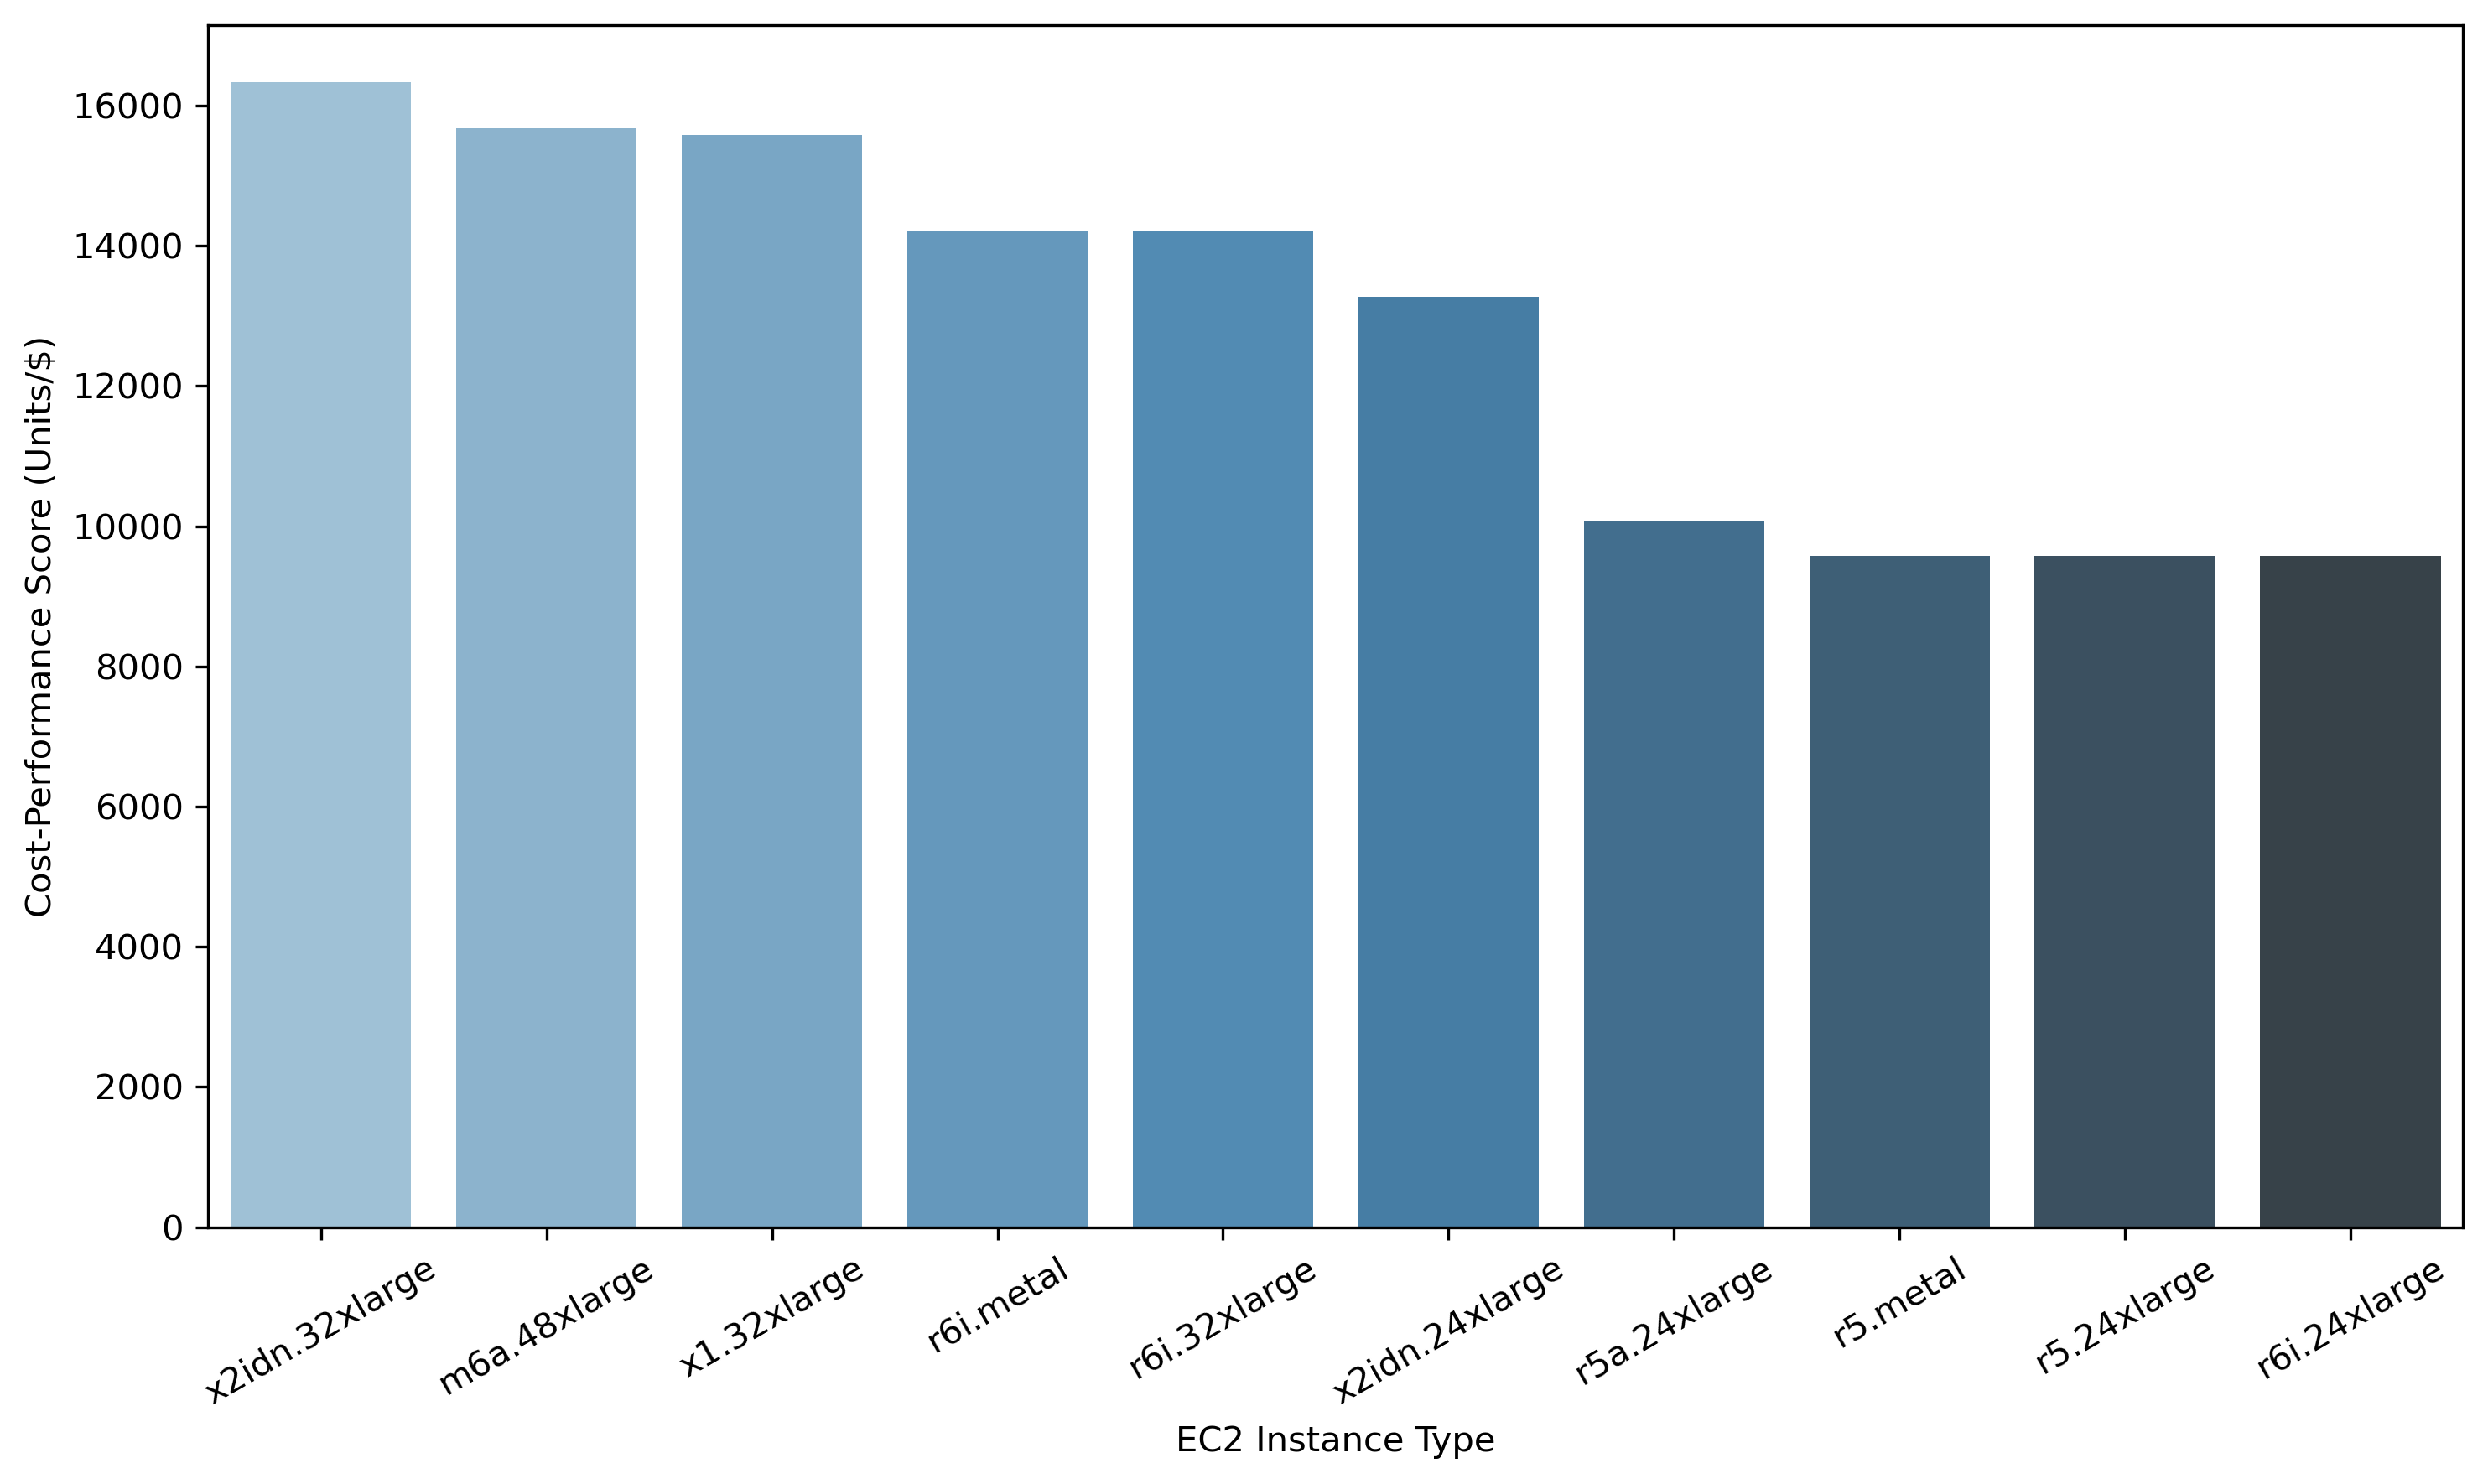

In [18]:
plt.figure(figsize=(10, 6), dpi=300)
sns.barplot(data=instances_df, x='Instance Type', y='Cost-Performance Score', palette='Blues_d')

plt.xlabel('EC2 Instance Type')
plt.ylabel('Cost-Performance Score (Units/$)')
plt.xticks(rotation=30)
plt.tight_layout()
# plt.savefig("cost-performance.tiff", dpi=300, bbox_inches='tight')
plt.show()

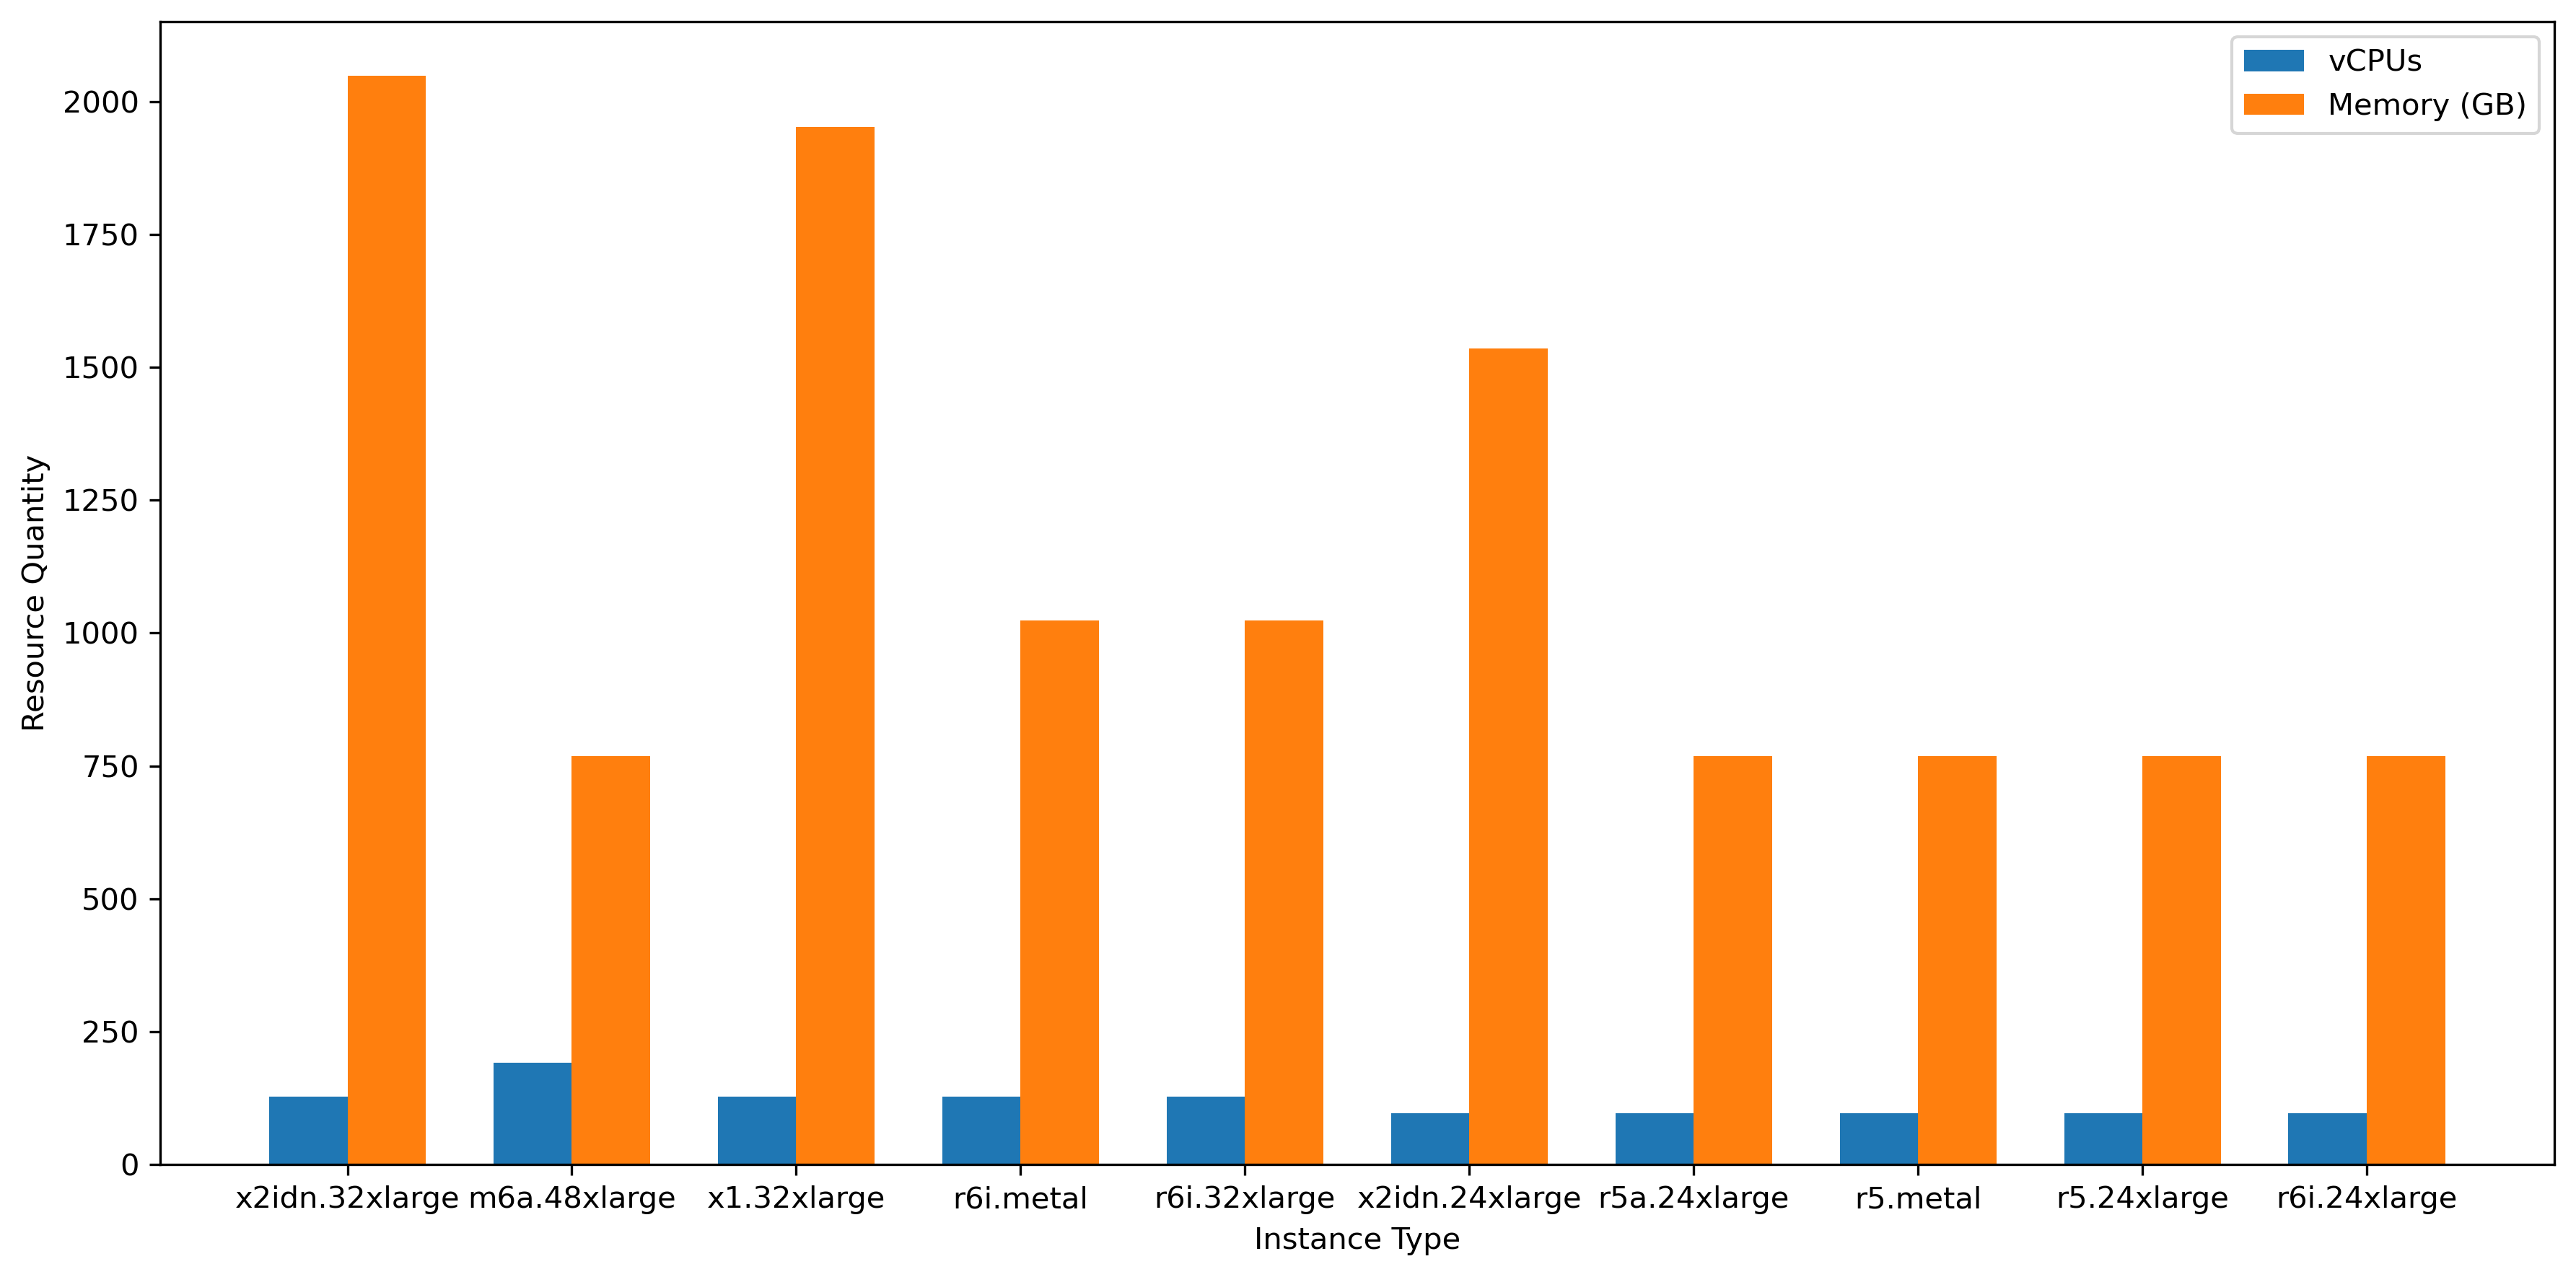

In [19]:
bar_width = 0.35

index = np.arange(len(instances_df))
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)
vcpu_bars = ax.bar(index, instances_df['vCPUs'], bar_width, label='vCPUs')
memory_bars = ax.bar(index + bar_width, instances_df['Memory (GB)'], bar_width, label='Memory (GB)')

ax.set_xlabel('Instance Type')
ax.set_ylabel('Resource Quantity')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(instances_df['Instance Type'])
ax.legend()

plt.tight_layout()
# plt.savefig("vcpu_memory.tiff", dpi=300, bbox_inches='tight')
plt.show()

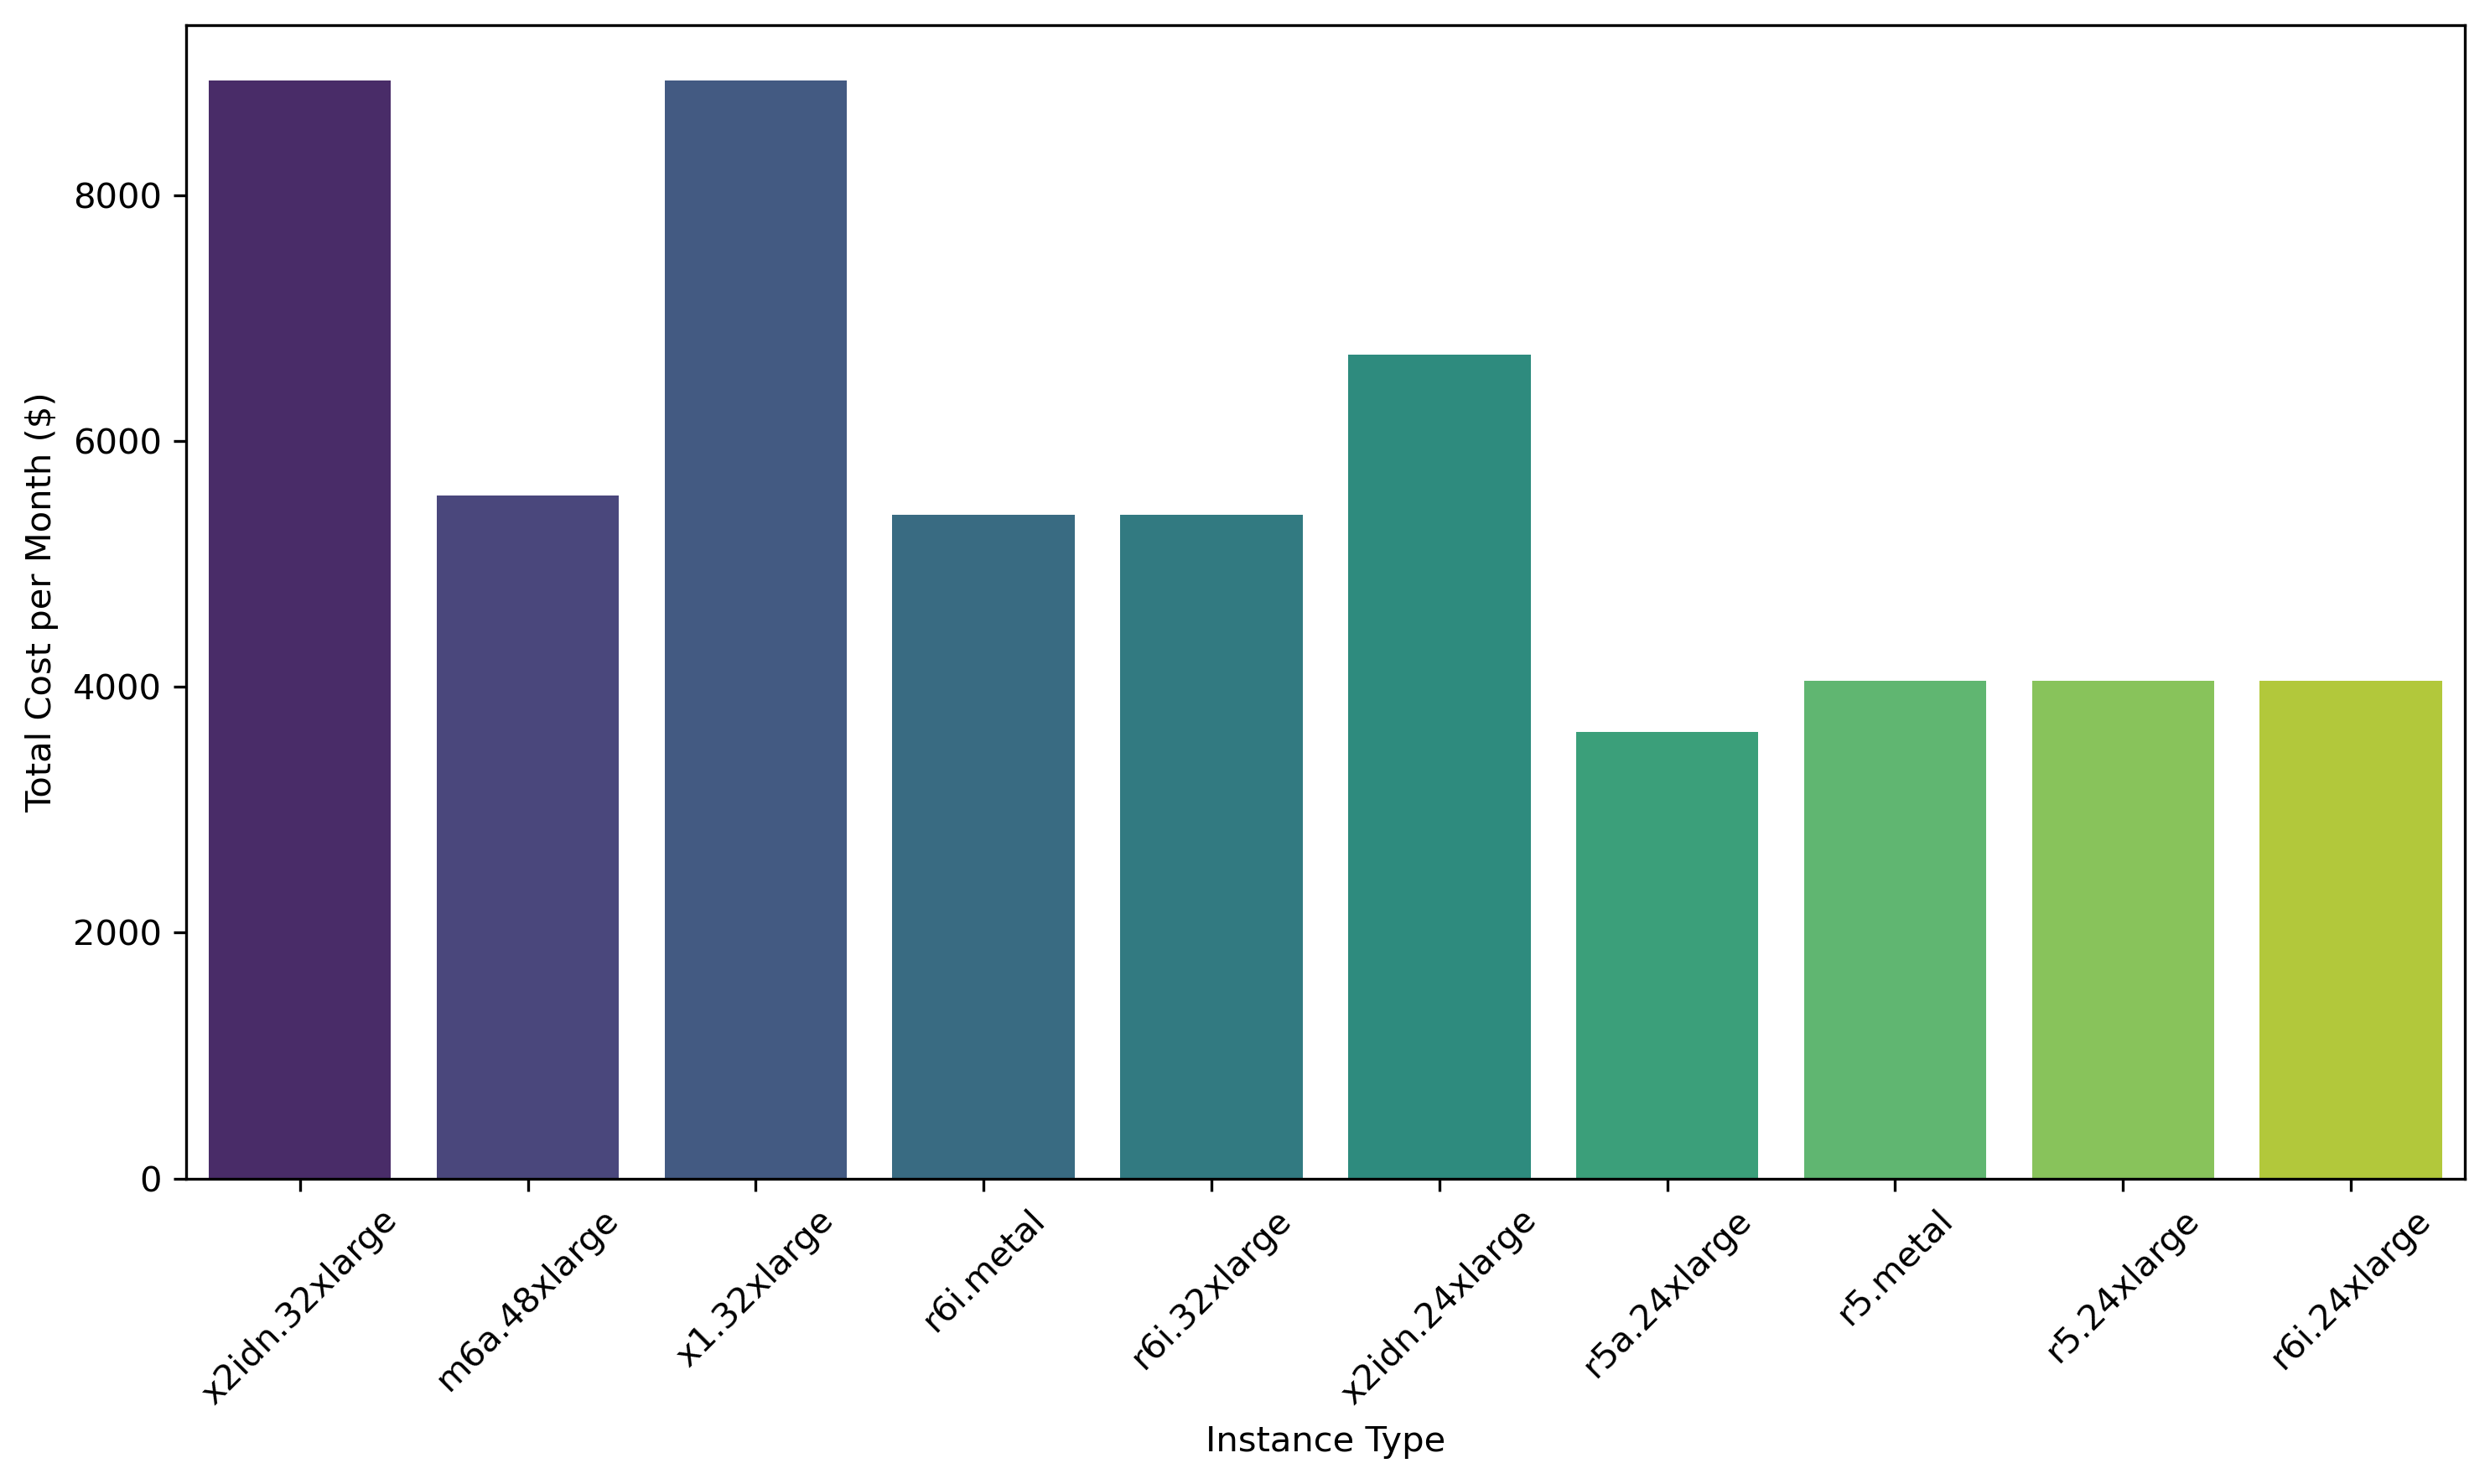

In [20]:
plt.figure(figsize=(10, 6), dpi=300)
sns.barplot(data=instances_df, x='Instance Type', y='Total Bill Per Month ($)', palette='viridis')

plt.xlabel('Instance Type')
plt.ylabel('Total Cost per Month ($)')
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig("total_cost.tiff", dpi=300, bbox_inches='tight')
plt.show()

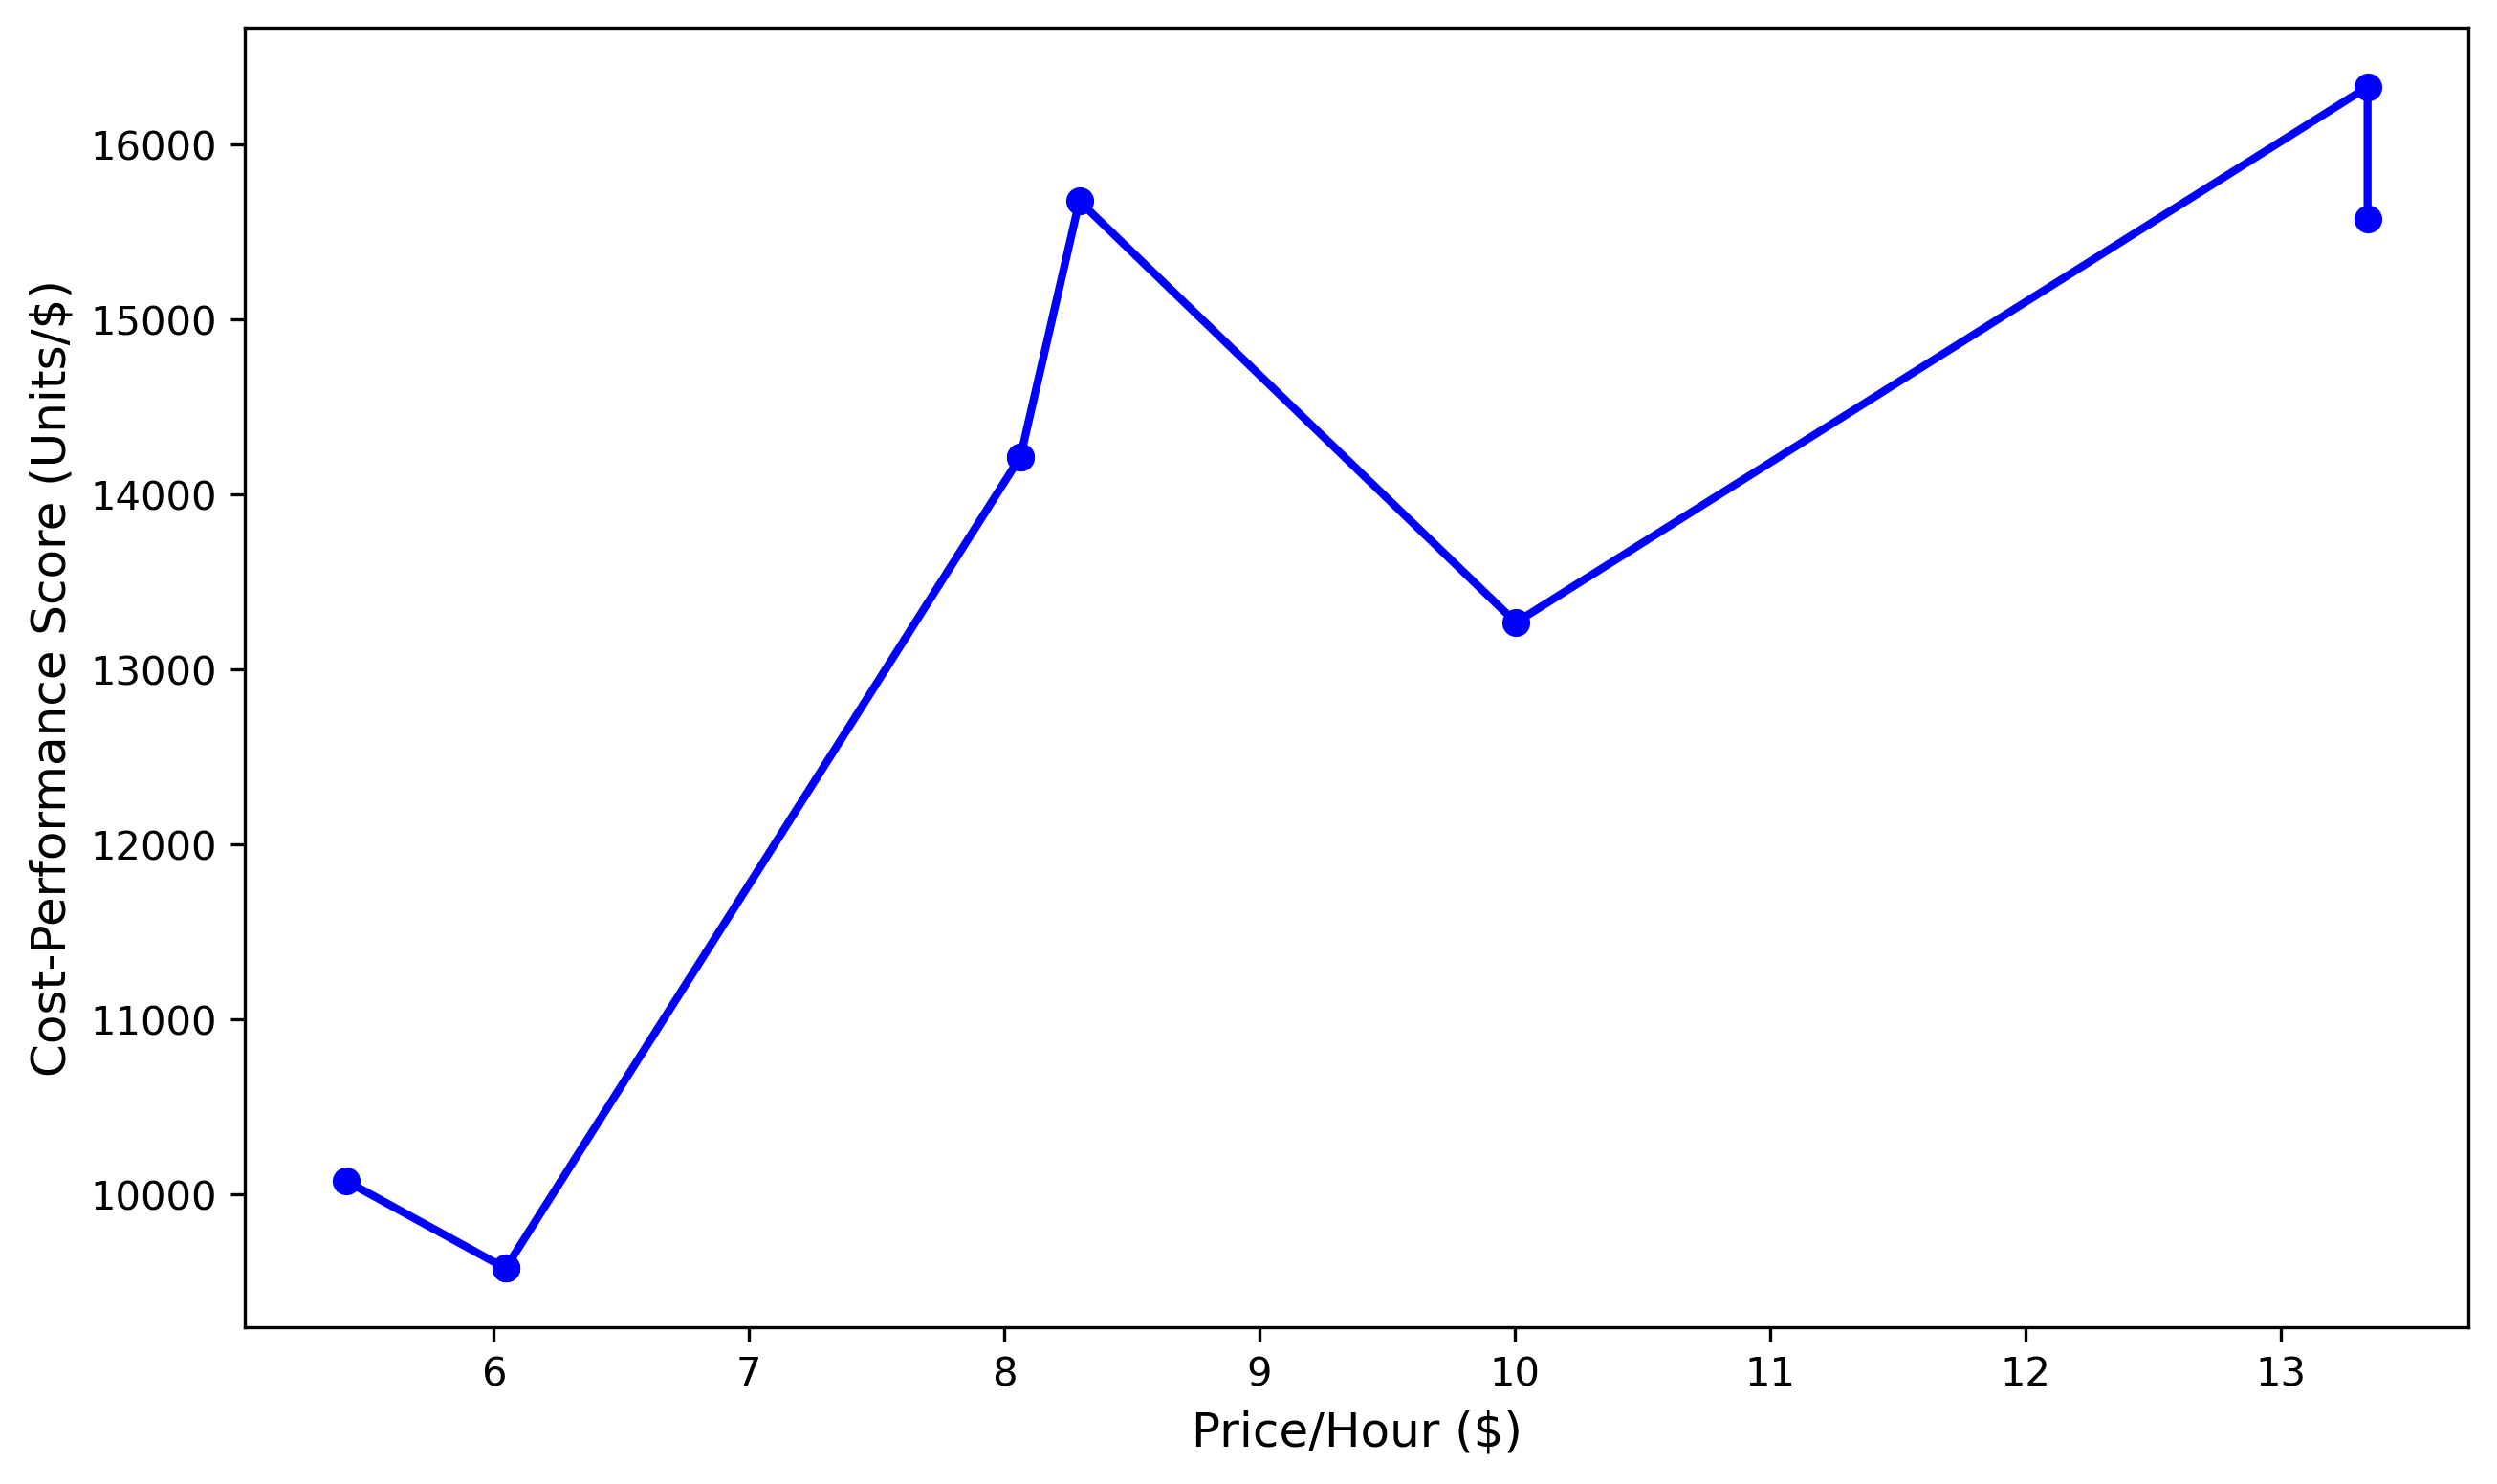

In [21]:
instances_df_sorted = instances_df.sort_values(by="Price/Hour ($)")

# Create a line plot for Cost vs. Performance
plt.figure(figsize=(10, 6), dpi=300)  # High resolution
plt.plot(instances_df_sorted["Price/Hour ($)"], instances_df_sorted["Cost-Performance Score"], color="b", marker="o", linestyle='-', linewidth=2)

# Adding labels and title
plt.xlabel("Price/Hour ($)", fontsize=12)
plt.ylabel("Cost-Performance Score (Units/$)", fontsize=12)


# Save the figure
# plt.savefig("cost_vs_performance_trend.tiff", dpi=300, bbox_inches='tight')
plt.show()

## Result 3

### **Parameters:**

**Region:** USA\
**Task Type:** High Performance Computing\
**Workload:** Very Heavy\
**Hours/Month:** 640\
**Monthly Budget for Instances (\$):** 11000\
**Volume Size (GB):** 500\
**Monthly Budget for Volumes (\$):** 3000

In [14]:
if __name__ == "__main__":
    # Base specifications per instance type and workload
    base_specs = {
        "general": {"Light": (1, 2), "Medium": (8, 16), "Heavy": (16, 32), "Very Heavy": (32, 64)},
        "memory": {"Light": (2, 16), "Medium": (8, 64), "Heavy": (24, 192), "Very Heavy": (48, 384)},
        "compute": {"Light": (4, 8), "Medium": (16, 32), "Heavy": (32, 64), "Very Heavy": (96, 192)}
    }

    green_data_centers = {
        "USA": ["us-east-1", "us-gov-east-1", "us-east-2", "us-west-2", "us-gov-west-1", "us-west-1"],
        "Canada": ["ca-central-1", "ca-west-1"],
        "Europe": [
            "eu-west-1", "eu-central-1", "eu-west-2", "eu-south-1", "eu-west-3", "eu-north-1", 
            "eu-south-2", "eu-central-2"
        ],
        "Asia-Pacific": ["ap-south-1", "ap-south-2", "ap-northeast-3", "ap-northeast-1"],
        "China": ["cn-north-1", "cn-northwest-1"]
    }


    # region, task_type, instance_type, workload, hours, budget = get_user_params()
    region, task_type, instance_type, workload, hours, budget = "USA", "hpc", "compute", "Very Heavy", 640, 11000
    
    size, budget = get_ebs_user_input()
    recommendations = recommend_ebs(task_type, size, budget)

    if recommendations:
        ebs_details = [
            {
                "EBS Type": rec['type'],
                "Price/GB ($)": rec['price_per_gb'],
                "Total Cost ($)": rec['total_cost'],
                "Max Throughput (MB/s)": rec['max_throughput'],
                "Max IOPS": rec['max_iops']
            }
            for rec in recommendations
        ]

        ebs_df = pd.DataFrame(ebs_details)
    else:
        print("No EBS volume within budget!")

    base_vcpu, base_ram, upper_vcpu, upper_ram = convert_workload_to_specs(base_specs, instance_type, workload)
    instance_prices = fetch_instance_pricing()
    optimal_instances = filter_optimal_instances(instance_prices, base_vcpu, base_ram, upper_vcpu, upper_ram, hours, budget)
    
    instances_df = None
    if optimal_instances:
        instance_details = [
            {
                "Instance Type": instance['instance_type'],
                "vCPUs": instance['vcpu'],
                "Memory (GB)": instance['memory'],
                "Price/Hour ($)": instance['price_per_hour'],
                "Total Bill Per Month ($)": instance['price_per_hour'] * hours,
                "Cost-Performance Score": instance['cost_performance_ratio']
            }
            for instance in optimal_instances[:10]
        ]

        # Convert the list of dictionaries into a pandas DataFrame
        instances_df = pd.DataFrame(instance_details)
        
        if region in set(green_data_centers.keys()):
            print(f"\nGood news! There are green AWS data centers available near your region ({region}). Choose any of these data centers to be green in your energy usage:\n{green_data_centers[region]}\n")
        else:
            print("There are no green AWS data centers available near your region unfortunately.\n\n")
    else:
        print("No instances found that meet your requirements and budget.")

Enter the required size of the volume (GB): 500
Enter your monthly budget for storage: $3000
Does your workload require very high IOPS (Y/N)? y
Please provide an estimate of the required IOPS: 20000

Good news! There are green AWS data centers available near your region (USA). Choose any of these data centers to be green in your energy usage:
['us-east-1', 'us-gov-east-1', 'us-east-2', 'us-west-2', 'us-gov-west-1', 'us-west-1']



In [15]:
ebs_df

,EBS Type,Price/GB ($),Total Cost ($),Max Throughput (MB/s),Max IOPS
0,io1,0.125,1362.5,1000 MB/s,64000


In [16]:
instances_df

,Instance Type,vCPUs,Memory (GB),Price/Hour ($),Total Bill Per Month ($),Cost-Performance Score
0,c6a.24xlarge,96,192.0,3.6720,2350.080,260.105866
1,c5a.24xlarge,96,192.0,3.6960,2365.440,251.699863
2,m5a.24xlarge,96,384.0,4.1280,2641.920,199.996349
3,m6a.24xlarge,96,384.0,4.1472,2654.208,192.278019
4,c5.metal,96,192.0,4.0800,2611.200,141.933139
5,c5.24xlarge,96,192.0,4.0800,2611.200,141.933139
6,c6i.24xlarge,96,192.0,4.0800,2611.200,141.933139
7,c5ad.24xlarge,96,192.0,4.1280,2641.920,131.372771
8,m5.24xlarge,96,384.0,4.6080,2949.120,59.123056
9,m6i.24xlarge,96,384.0,4.6080,2949.120,59.123056


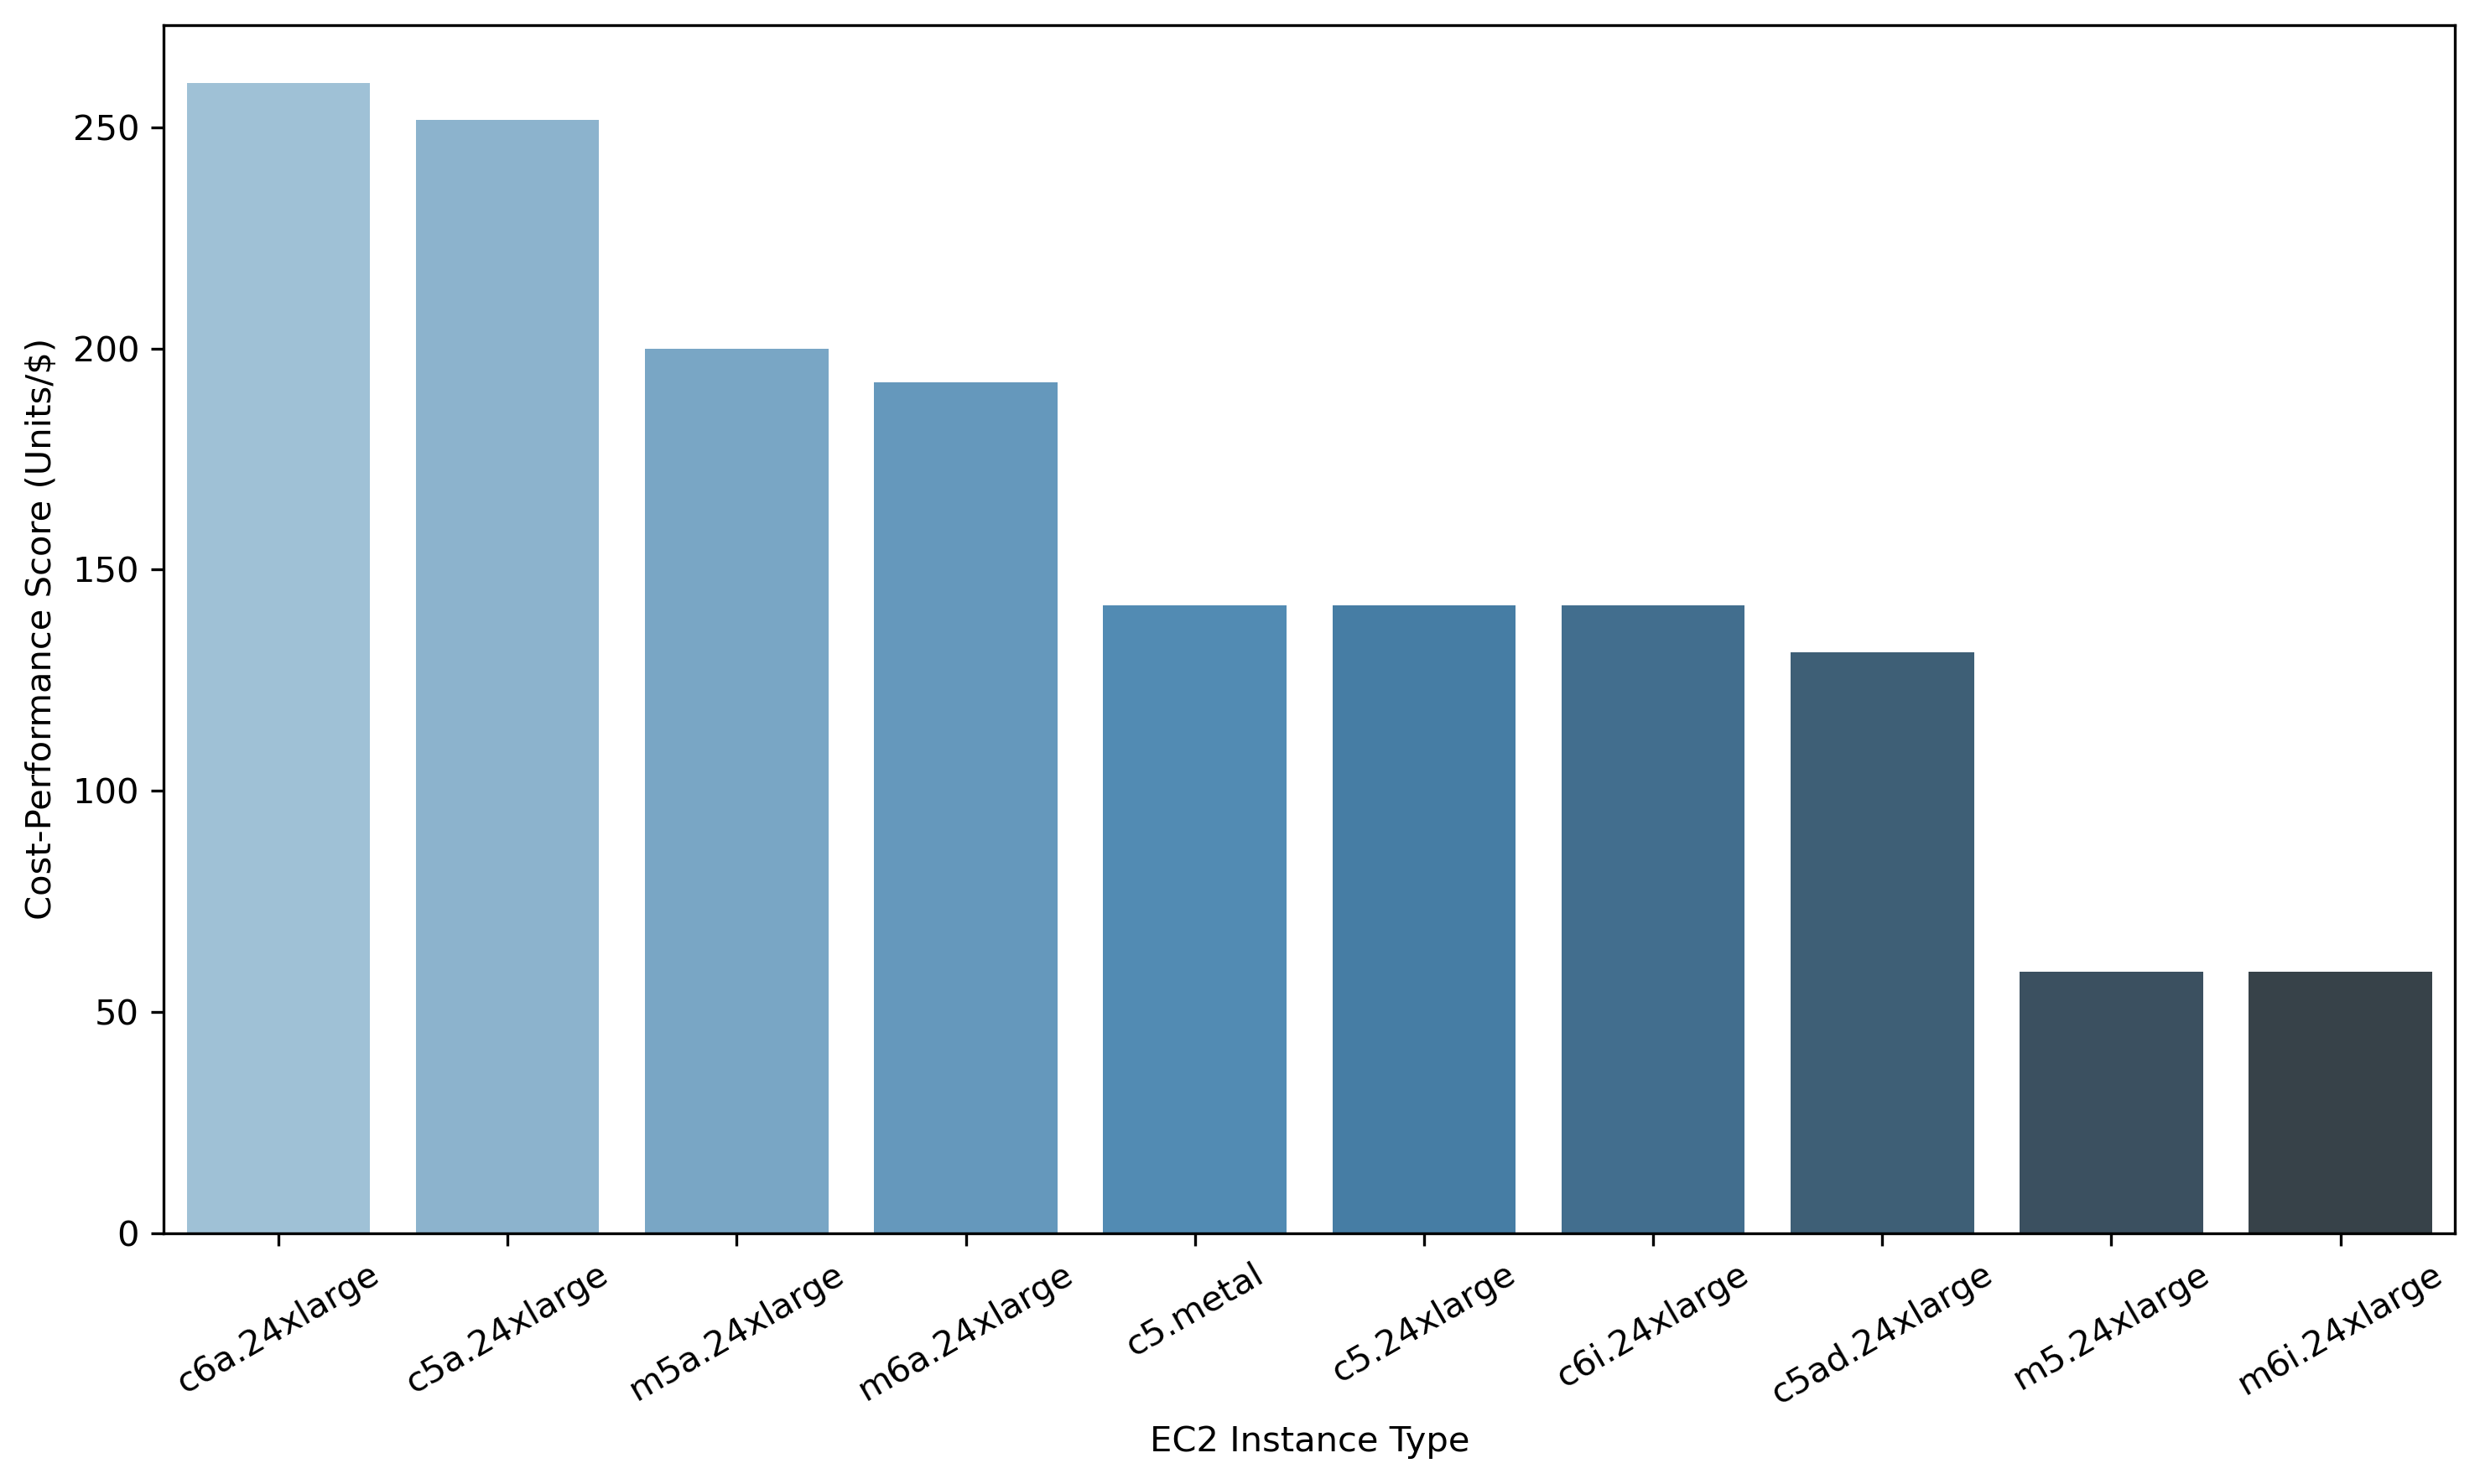

In [17]:
plt.figure(figsize=(10, 6), dpi=300)
sns.barplot(data=instances_df, x='Instance Type', y='Cost-Performance Score', palette='Blues_d')

plt.xlabel('EC2 Instance Type')
plt.ylabel('Cost-Performance Score (Units/$)')
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("cost-performance3.eps", dpi=300, bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


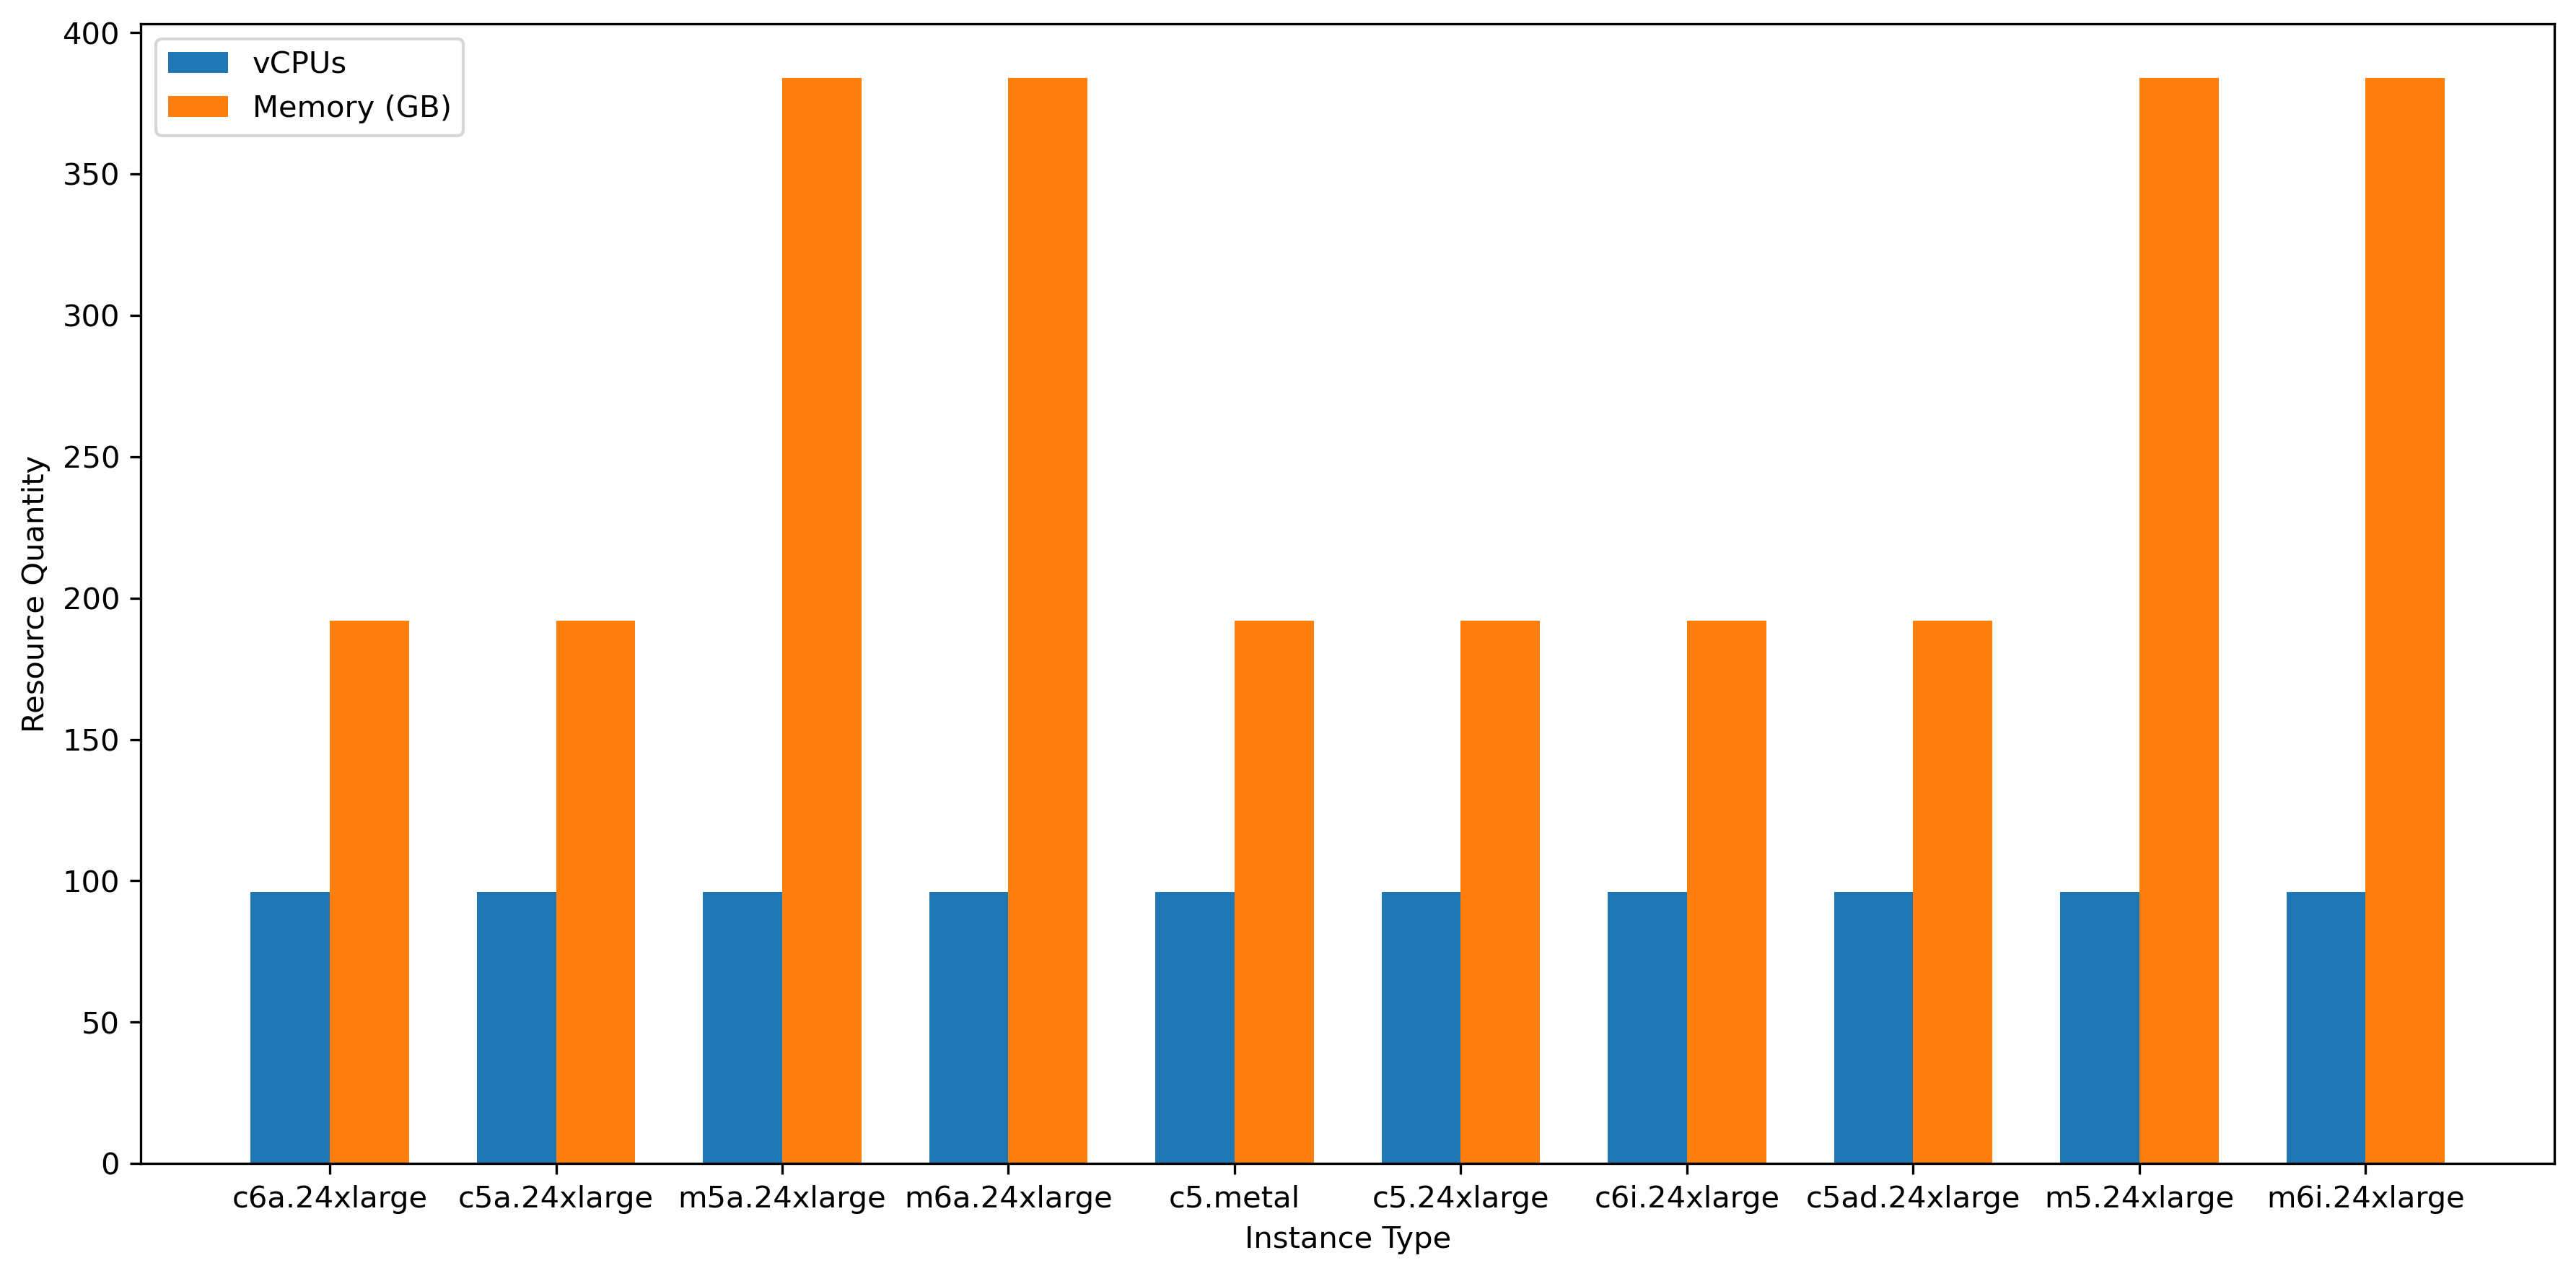

In [18]:
bar_width = 0.35

index = np.arange(len(instances_df))
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)
vcpu_bars = ax.bar(index, instances_df['vCPUs'], bar_width, label='vCPUs')
memory_bars = ax.bar(index + bar_width, instances_df['Memory (GB)'], bar_width, label='Memory (GB)')

ax.set_xlabel('Instance Type')
ax.set_ylabel('Resource Quantity')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(instances_df['Instance Type'])
ax.legend()

plt.tight_layout()
plt.savefig("vcpu_memory3.eps", dpi=300, bbox_inches='tight')
plt.show()

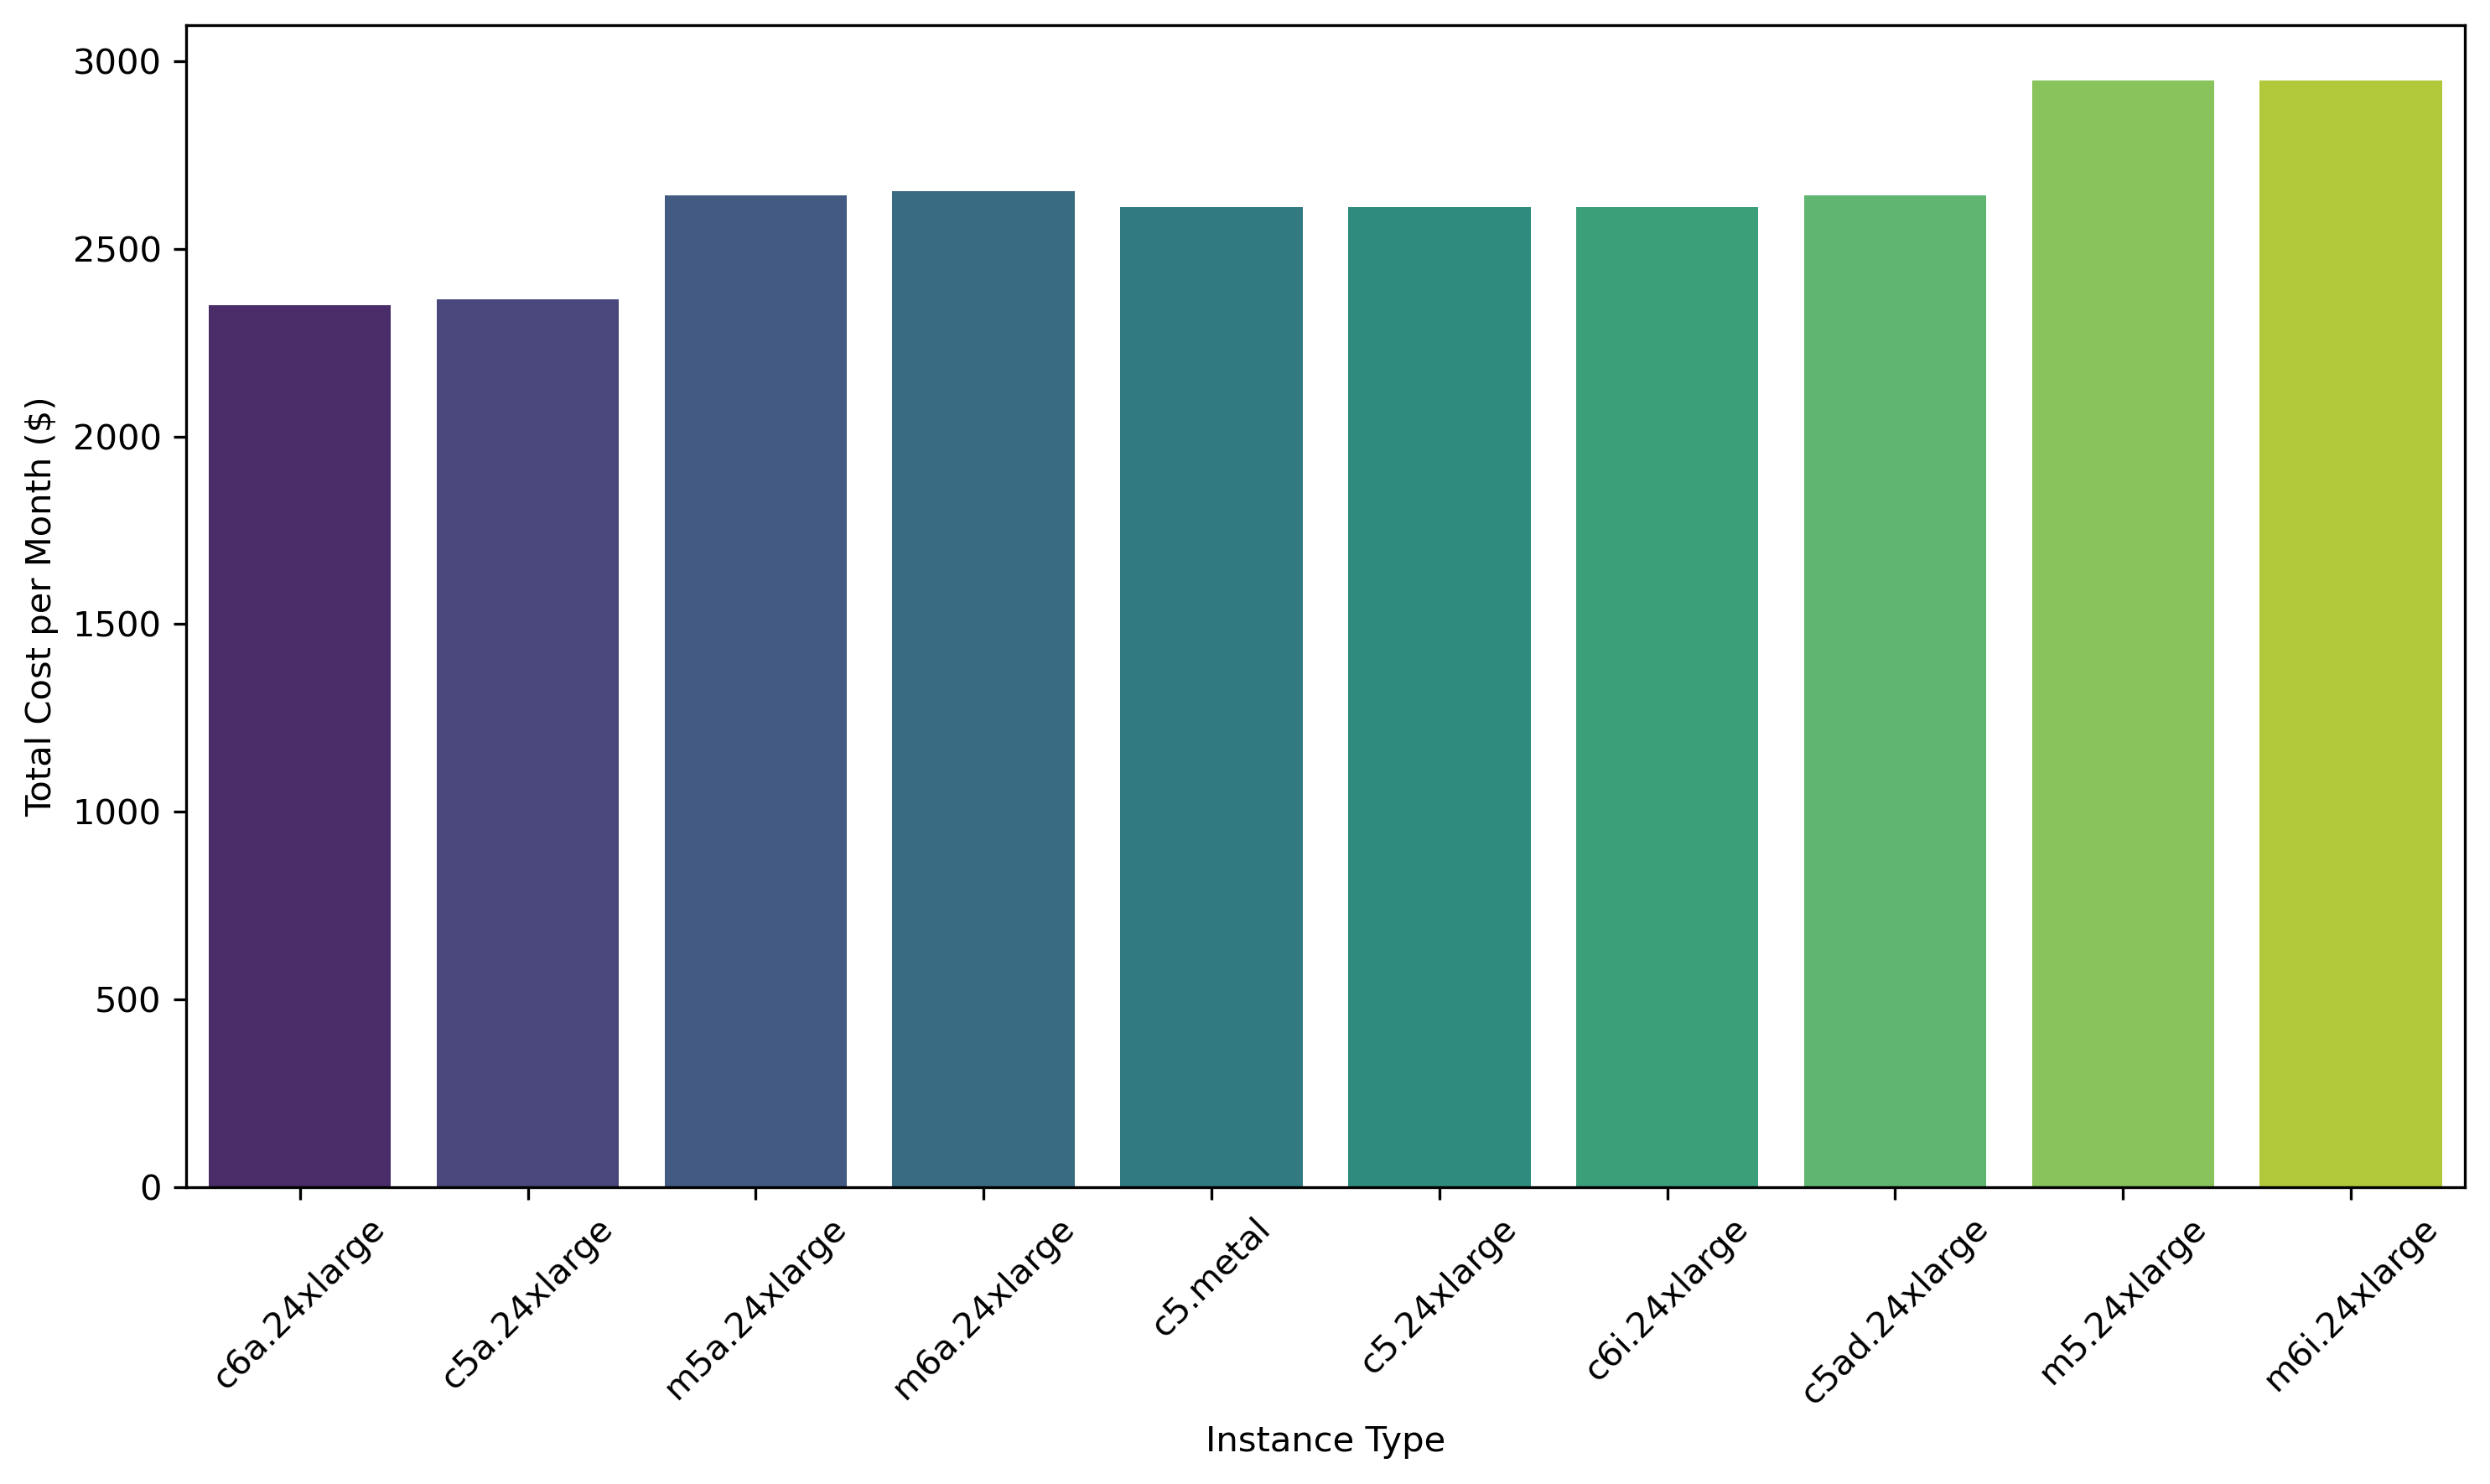

In [19]:
plt.figure(figsize=(10, 6), dpi=300)
sns.barplot(data=instances_df, x='Instance Type', y='Total Bill Per Month ($)', palette='viridis')

plt.xlabel('Instance Type')
plt.ylabel('Total Cost per Month ($)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("total_cost3.eps", dpi=300, bbox_inches='tight')
plt.show()

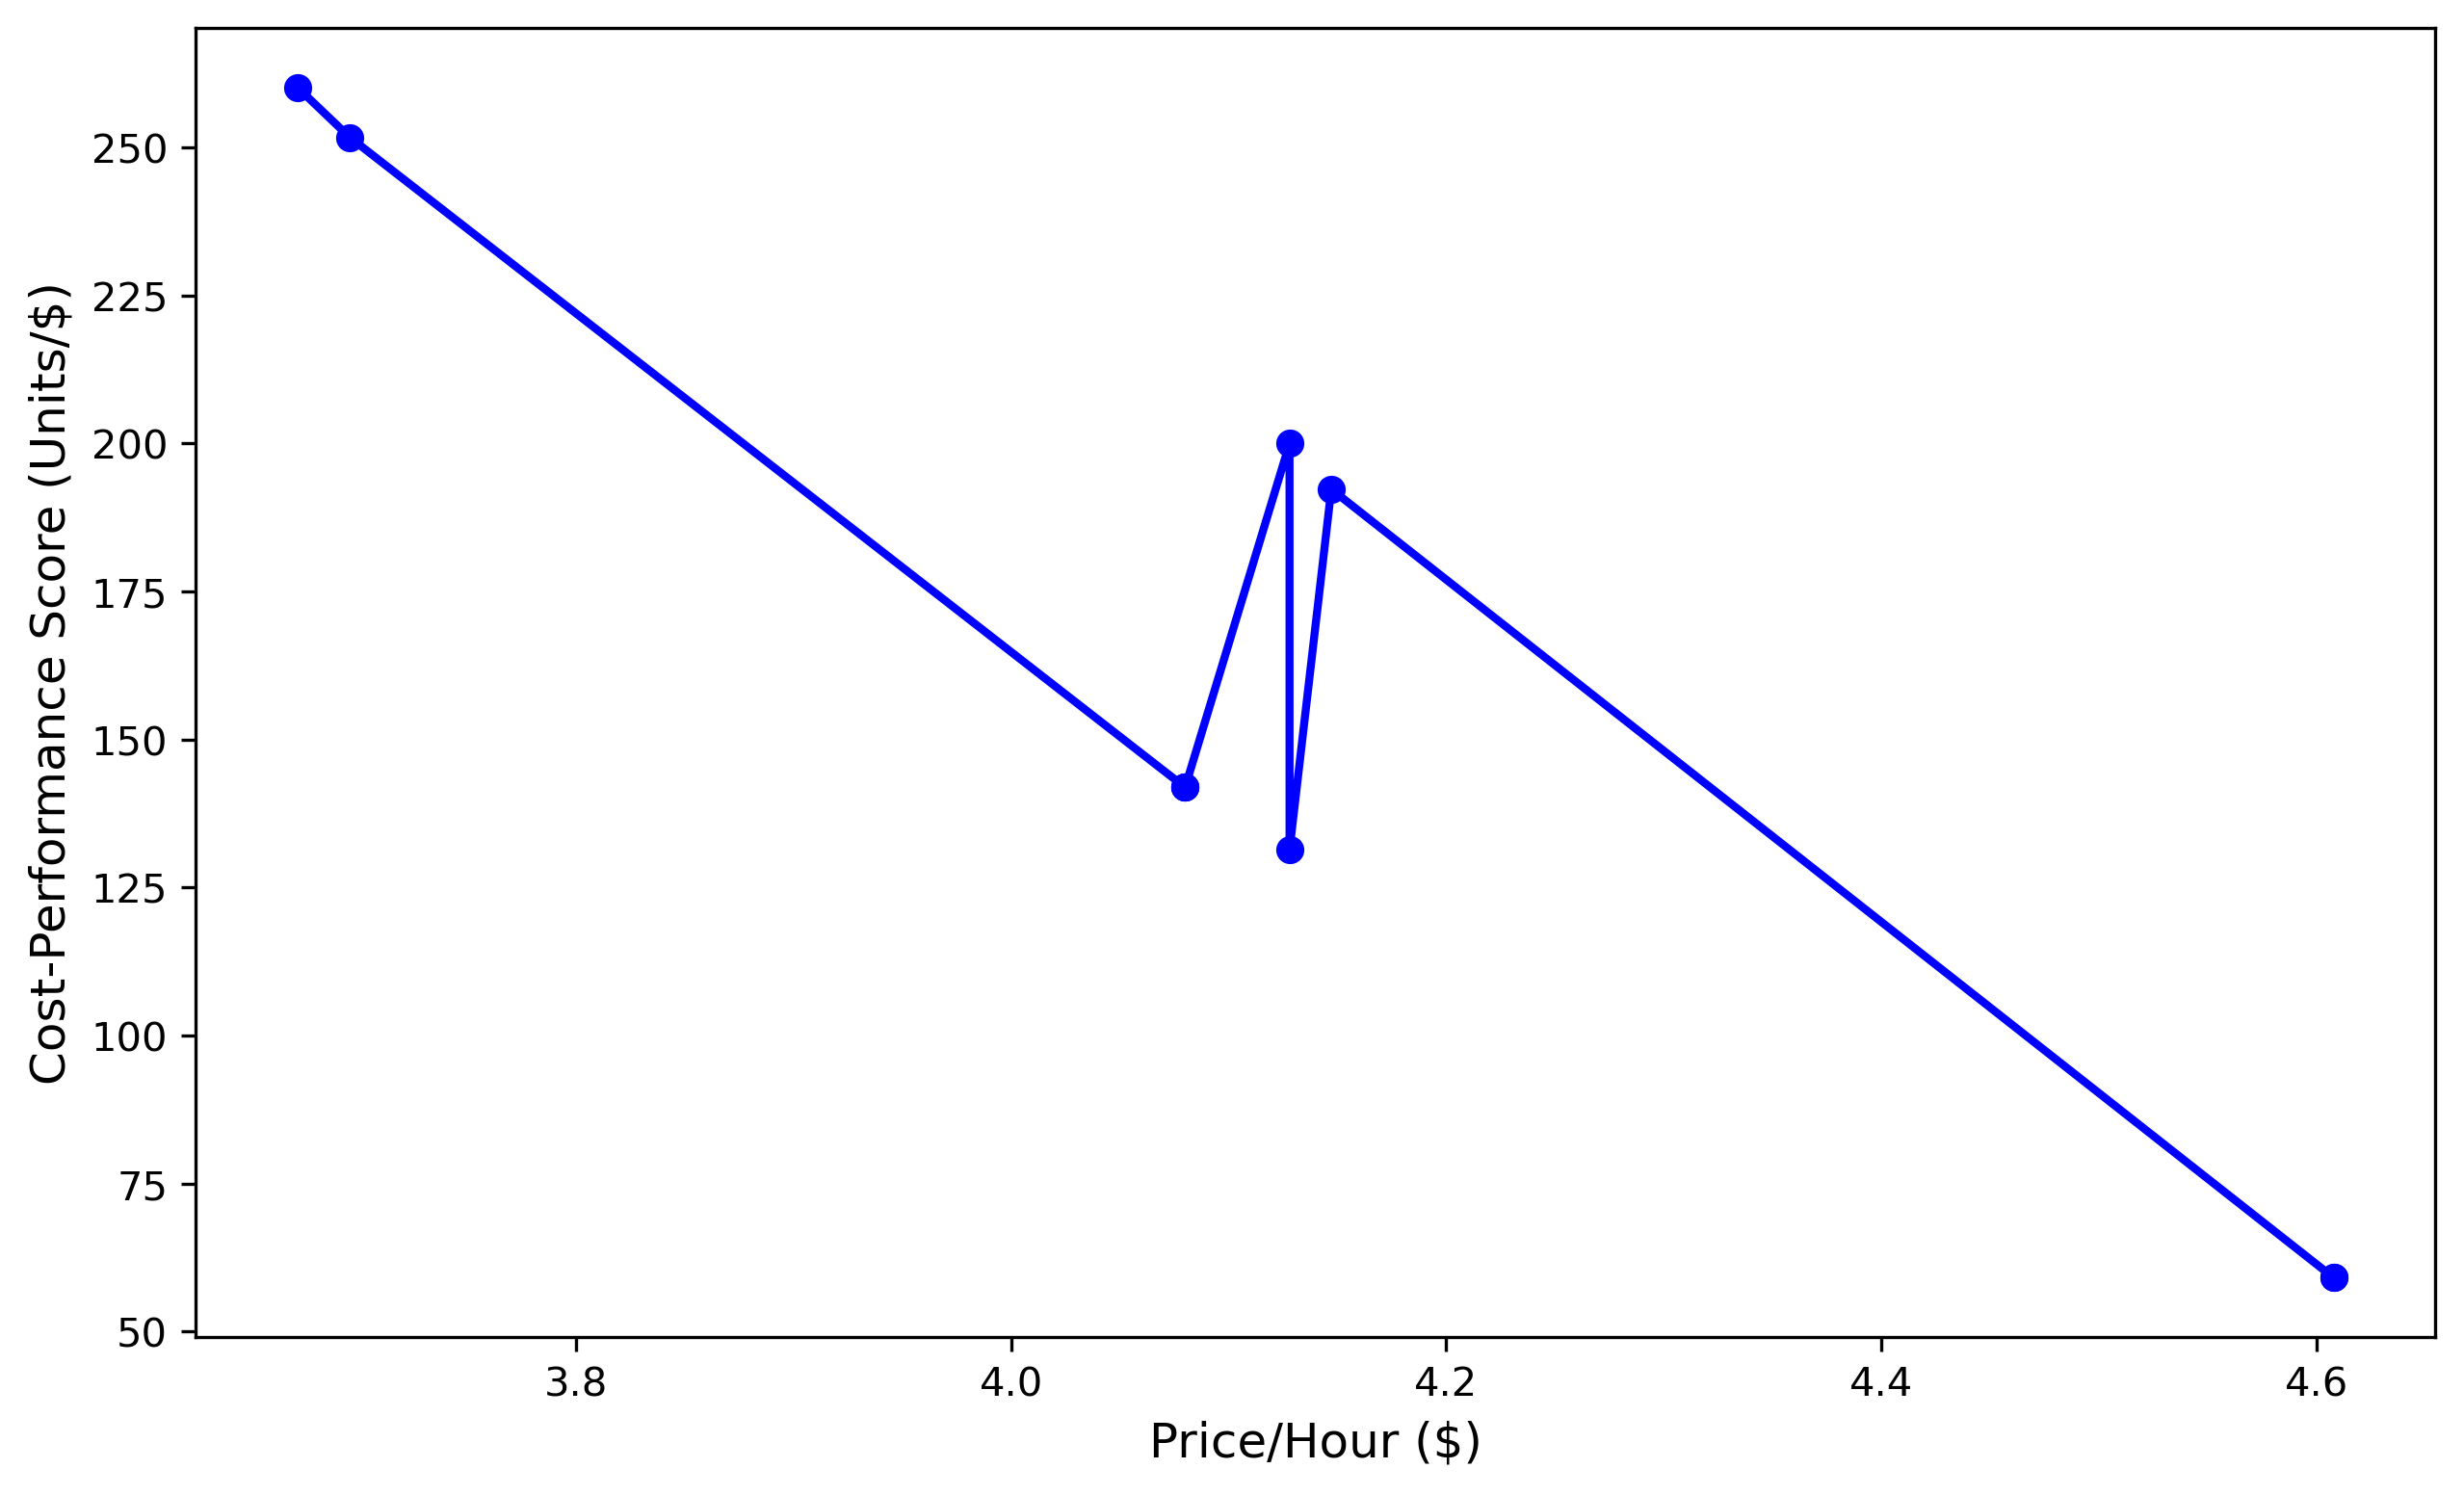

In [20]:
instances_df_sorted = instances_df.sort_values(by="Price/Hour ($)")

# Create a line plot for Cost vs. Performance
plt.figure(figsize=(10, 6), dpi=300)  # High resolution
plt.plot(instances_df_sorted["Price/Hour ($)"], instances_df_sorted["Cost-Performance Score"], color="b", marker="o", linestyle='-', linewidth=2)

# Adding labels and title
plt.xlabel("Price/Hour ($)", fontsize=12)
plt.ylabel("Cost-Performance Score (Units/$)", fontsize=12)


# Save the figure
plt.savefig("cost_vs_performance_trend3.eps", dpi=300, bbox_inches='tight')
plt.show()

## Live Demo

Run the cells below this text to run this code for yourself.

In [31]:
if __name__ == "__main__":
    # Base specifications per instance type and workload
    base_specs = {
        "general": {"Light": (1, 2), "Medium": (8, 16), "Heavy": (16, 32), "Very Heavy": (32, 64)},
        "memory": {"Light": (2, 16), "Medium": (8, 64), "Heavy": (24, 192), "Very Heavy": (48, 384)},
        "compute": {"Light": (4, 8), "Medium": (16, 32), "Heavy": (32, 64), "Very Heavy": (96, 192)}
    }

    green_data_centers = {
        "USA": ["us-east-1", "us-gov-east-1", "us-east-2", "us-west-2", "us-gov-west-1", "us-west-1"],
        "Canada": ["ca-central-1", "ca-west-1"],
        "Europe": [
            "eu-west-1", "eu-central-1", "eu-west-2", "eu-south-1", "eu-west-3", "eu-north-1", 
            "eu-south-2", "eu-central-2"
        ],
        "Asia-Pacific": ["ap-south-1", "ap-south-2", "ap-northeast-3", "ap-northeast-1"],
        "China": ["cn-north-1", "cn-northwest-1"]
    }


    region, task_type, instance_type, workload, hours, budget = get_user_params()
    
    size, budget = get_ebs_user_input()
    recommendations = recommend_ebs(task_type, size, budget)

    if recommendations:
        ebs_details = [
            {
                "EBS Type": rec['type'],
                "Price/GB ($)": rec['price_per_gb'],
                "Total Cost ($)": rec['total_cost'],
                "Max Throughput (MB/s)": rec['max_throughput'],
                "Max IOPS": rec['max_iops']
            }
            for rec in recommendations
        ]

        ebs_df = pd.DataFrame(ebs_details)
    else:
        print("No EBS volume within budget!")

    base_vcpu, base_ram, upper_vcpu, upper_ram = convert_workload_to_specs(base_specs, instance_type, workload)
    instance_prices = fetch_instance_pricing()
    optimal_instances = filter_optimal_instances(instance_prices, base_vcpu, base_ram, upper_vcpu, upper_ram, hours, budget)
    
    instances_df = None
    if optimal_instances:
        instance_details = [
            {
                "Instance Type": instance['instance_type'],
                "vCPUs": instance['vcpu'],
                "Memory (GB)": instance['memory'],
                "Price/Hour ($)": instance['price_per_hour'],
                "Total Bill Per Month ($)": instance['price_per_hour'] * hours,
                "Cost-Performance Score": instance['cost_performance_ratio']
            }
            for instance in optimal_instances[:10]
        ]

        # Convert the list of dictionaries into a pandas DataFrame
        instances_df = pd.DataFrame(instance_details)
        
        if region in set(green_data_centers.keys()):
            print(f"\nGood news! There are green AWS data centers available near your region ({region}). Choose any of these data centers to be green in your energy usage:\n{green_data_centers[region]}\n")
        else:
            print("There are no green AWS data centers available near your region unfortunately.\n\n")
    else:
        print("No instances found that meet your requirements and budget.")

Enter the region you wish to host your instance: Europe
What will the instance be used for: Dev
Enter the Expected Workload (e.g., Light, Medium, Heavy, Very Heavy): Very Heavy
Enter the number of hours the instance will run in a week: 50
Enter your monthly budget for instances: $1000
Enter the required size of the volume (GB): 500
Enter your monthly budget for storage: $1000
Does your workload require very high IOPS (Y/N)? n

Good news! There are green AWS data centers available near your region (Europe). Choose any of these data centers to be green in your energy usage:
['eu-west-1', 'eu-central-1', 'eu-west-2', 'eu-south-1', 'eu-west-3', 'eu-north-1', 'eu-south-2', 'eu-central-2']



In [32]:
ebs_df

,EBS Type,Price/GB ($),Total Cost ($),Max Throughput (MB/s),Max IOPS
0,gp3,0.08,40.0,1000 MB/s,16000
1,gp2,0.10,50.0,250 MB/s,16000


In [33]:
instances_df

,Instance Type,vCPUs,Memory (GB),Price/Hour ($),Total Bill Per Month ($),Cost-Performance Score
0,r6g.12xlarge,48,384.0,2.4192,483.84,1049.753828
1,m6g.16xlarge,64,256.0,2.4640,492.80,915.632114
2,m6g.metal,64,256.0,2.4640,492.80,915.632114
3,r6g.metal,64,512.0,3.2256,645.12,906.025448
4,r6g.16xlarge,64,512.0,3.2256,645.12,906.025448
5,r5a.12xlarge,48,384.0,2.7120,542.40,838.203459
6,r6gd.12xlarge,48,384.0,2.7648,552.96,802.730707
7,r6g.8xlarge,32,256.0,1.6128,322.56,801.994491
8,m6g.12xlarge,48,192.0,1.8480,369.60,791.455667
9,x2gd.8xlarge,32,512.0,2.6720,534.40,765.563334


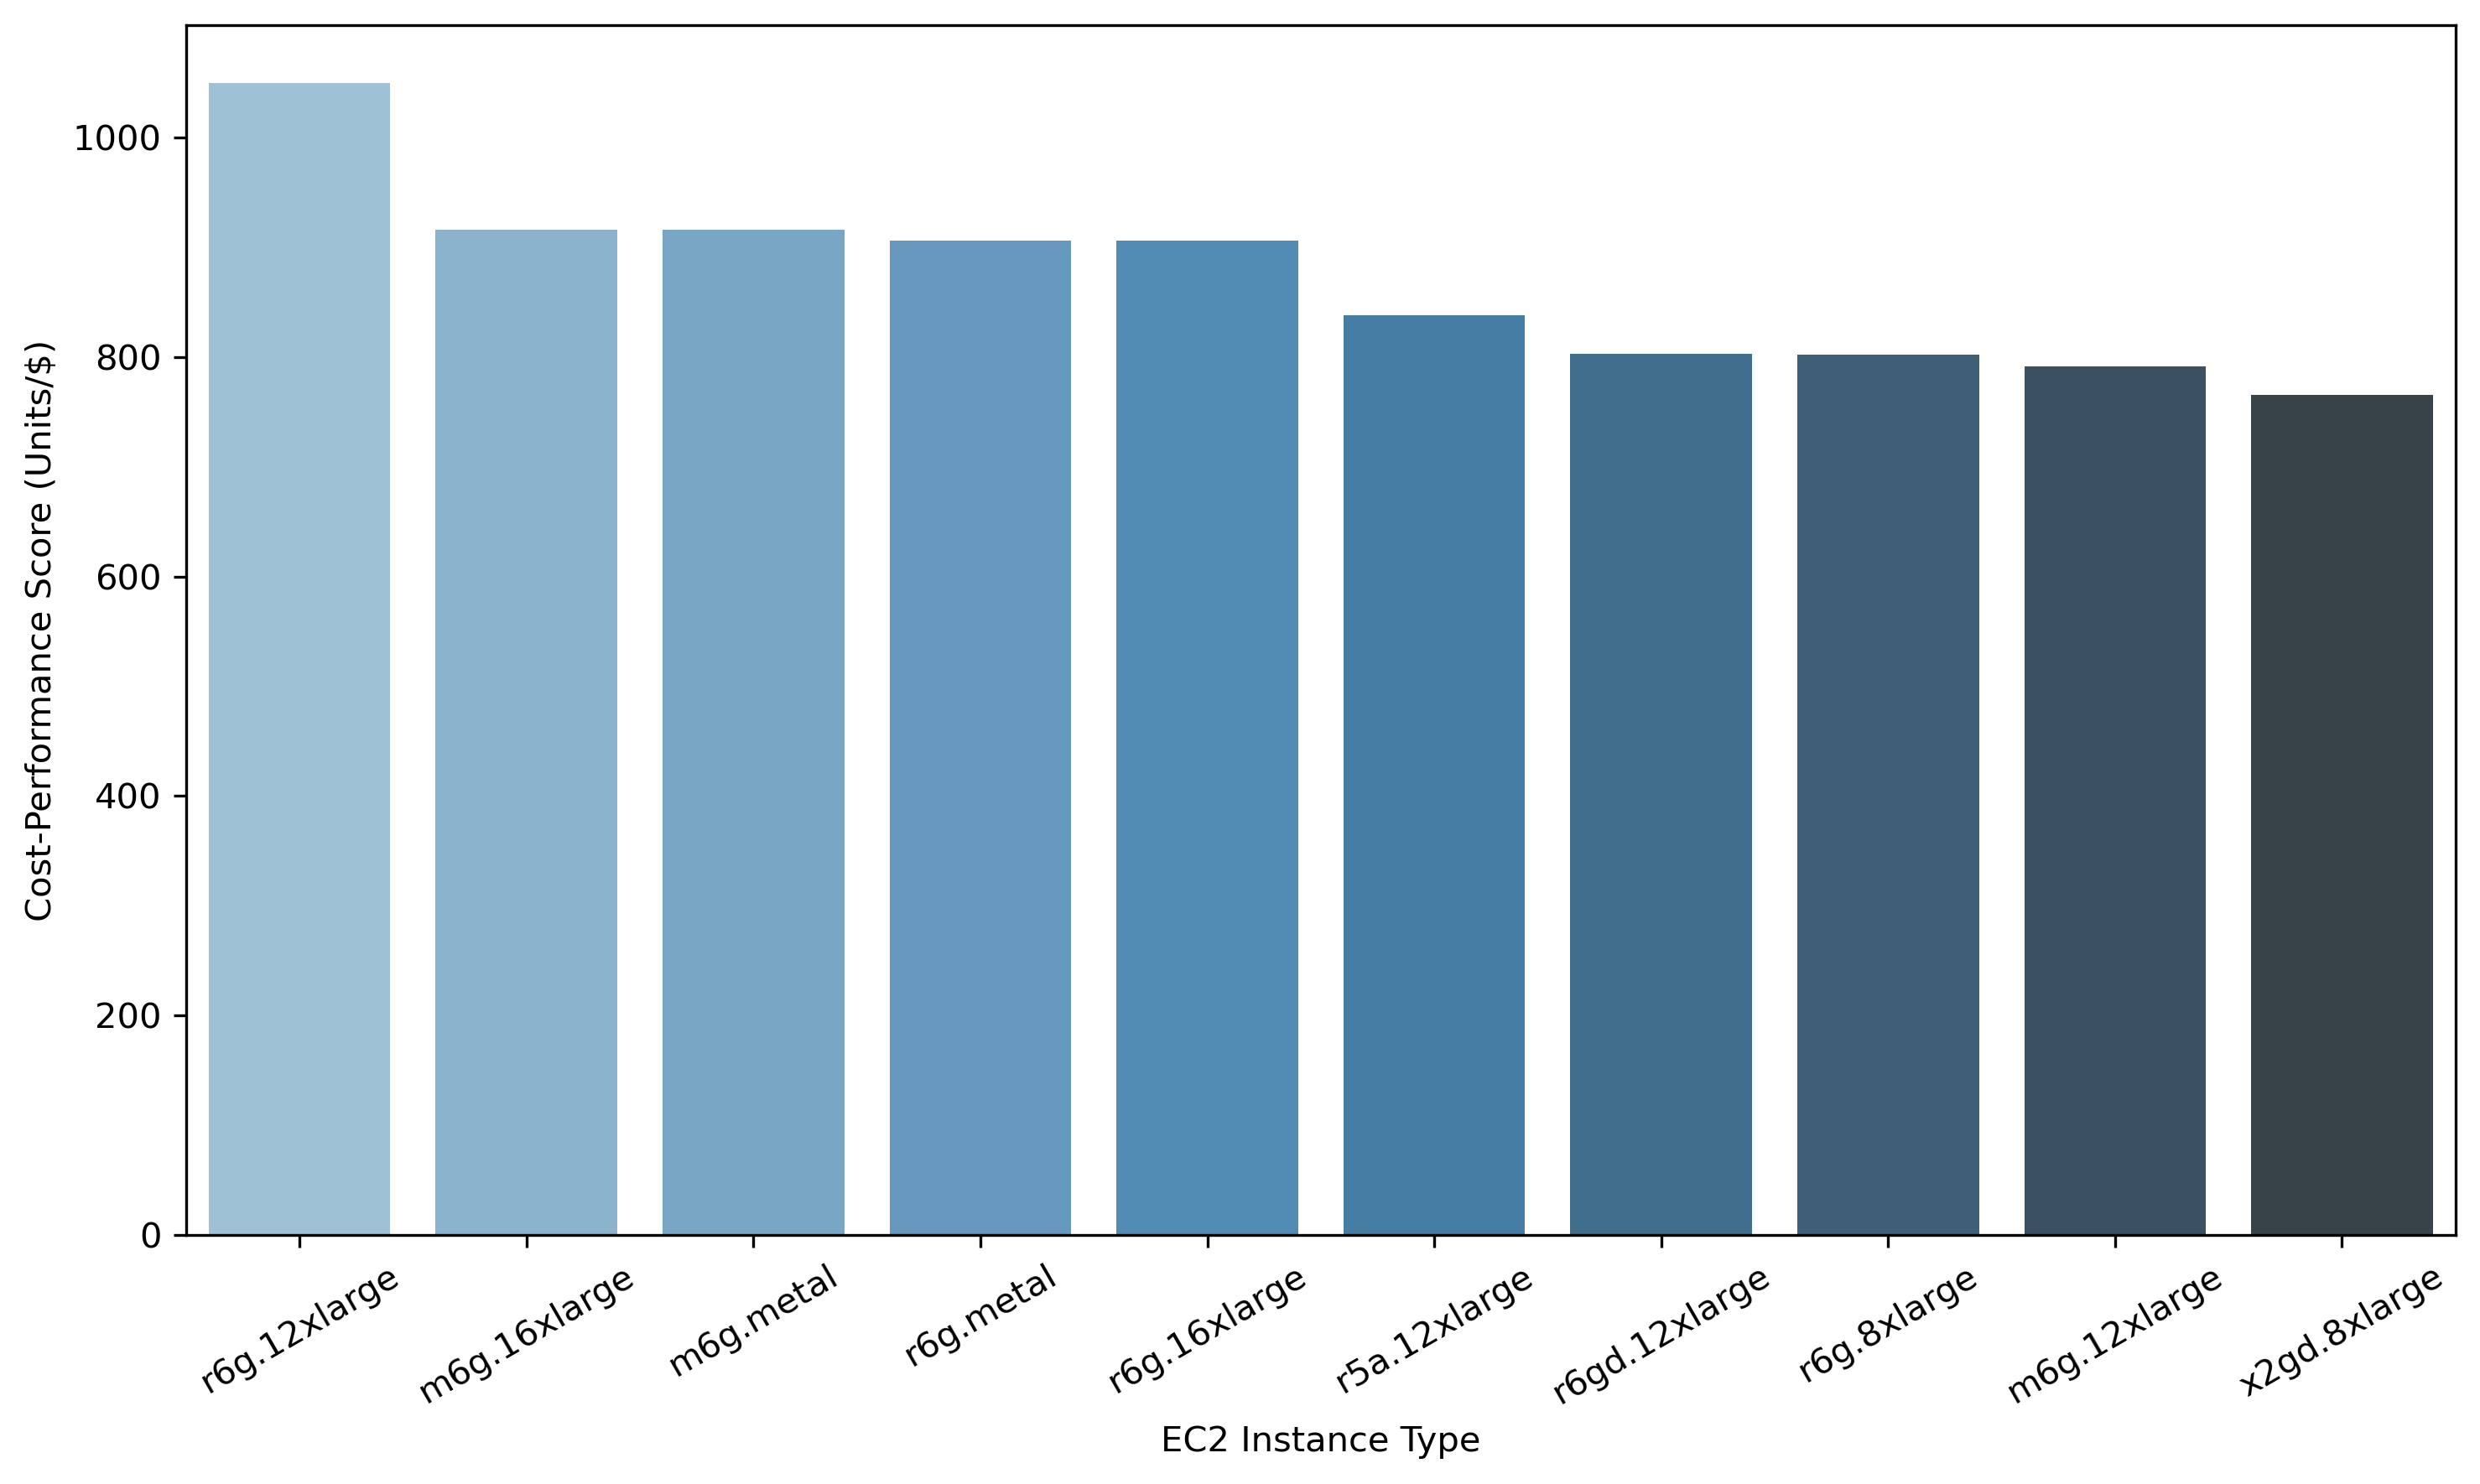

In [34]:
plt.figure(figsize=(10, 6), dpi=300)
sns.barplot(data=instances_df, x='Instance Type', y='Cost-Performance Score', palette='Blues_d')

plt.xlabel('EC2 Instance Type')
plt.ylabel('Cost-Performance Score (Units/$)')
plt.xticks(rotation=30)
plt.tight_layout()
# plt.savefig("cost-performance3.eps", dpi=300, bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


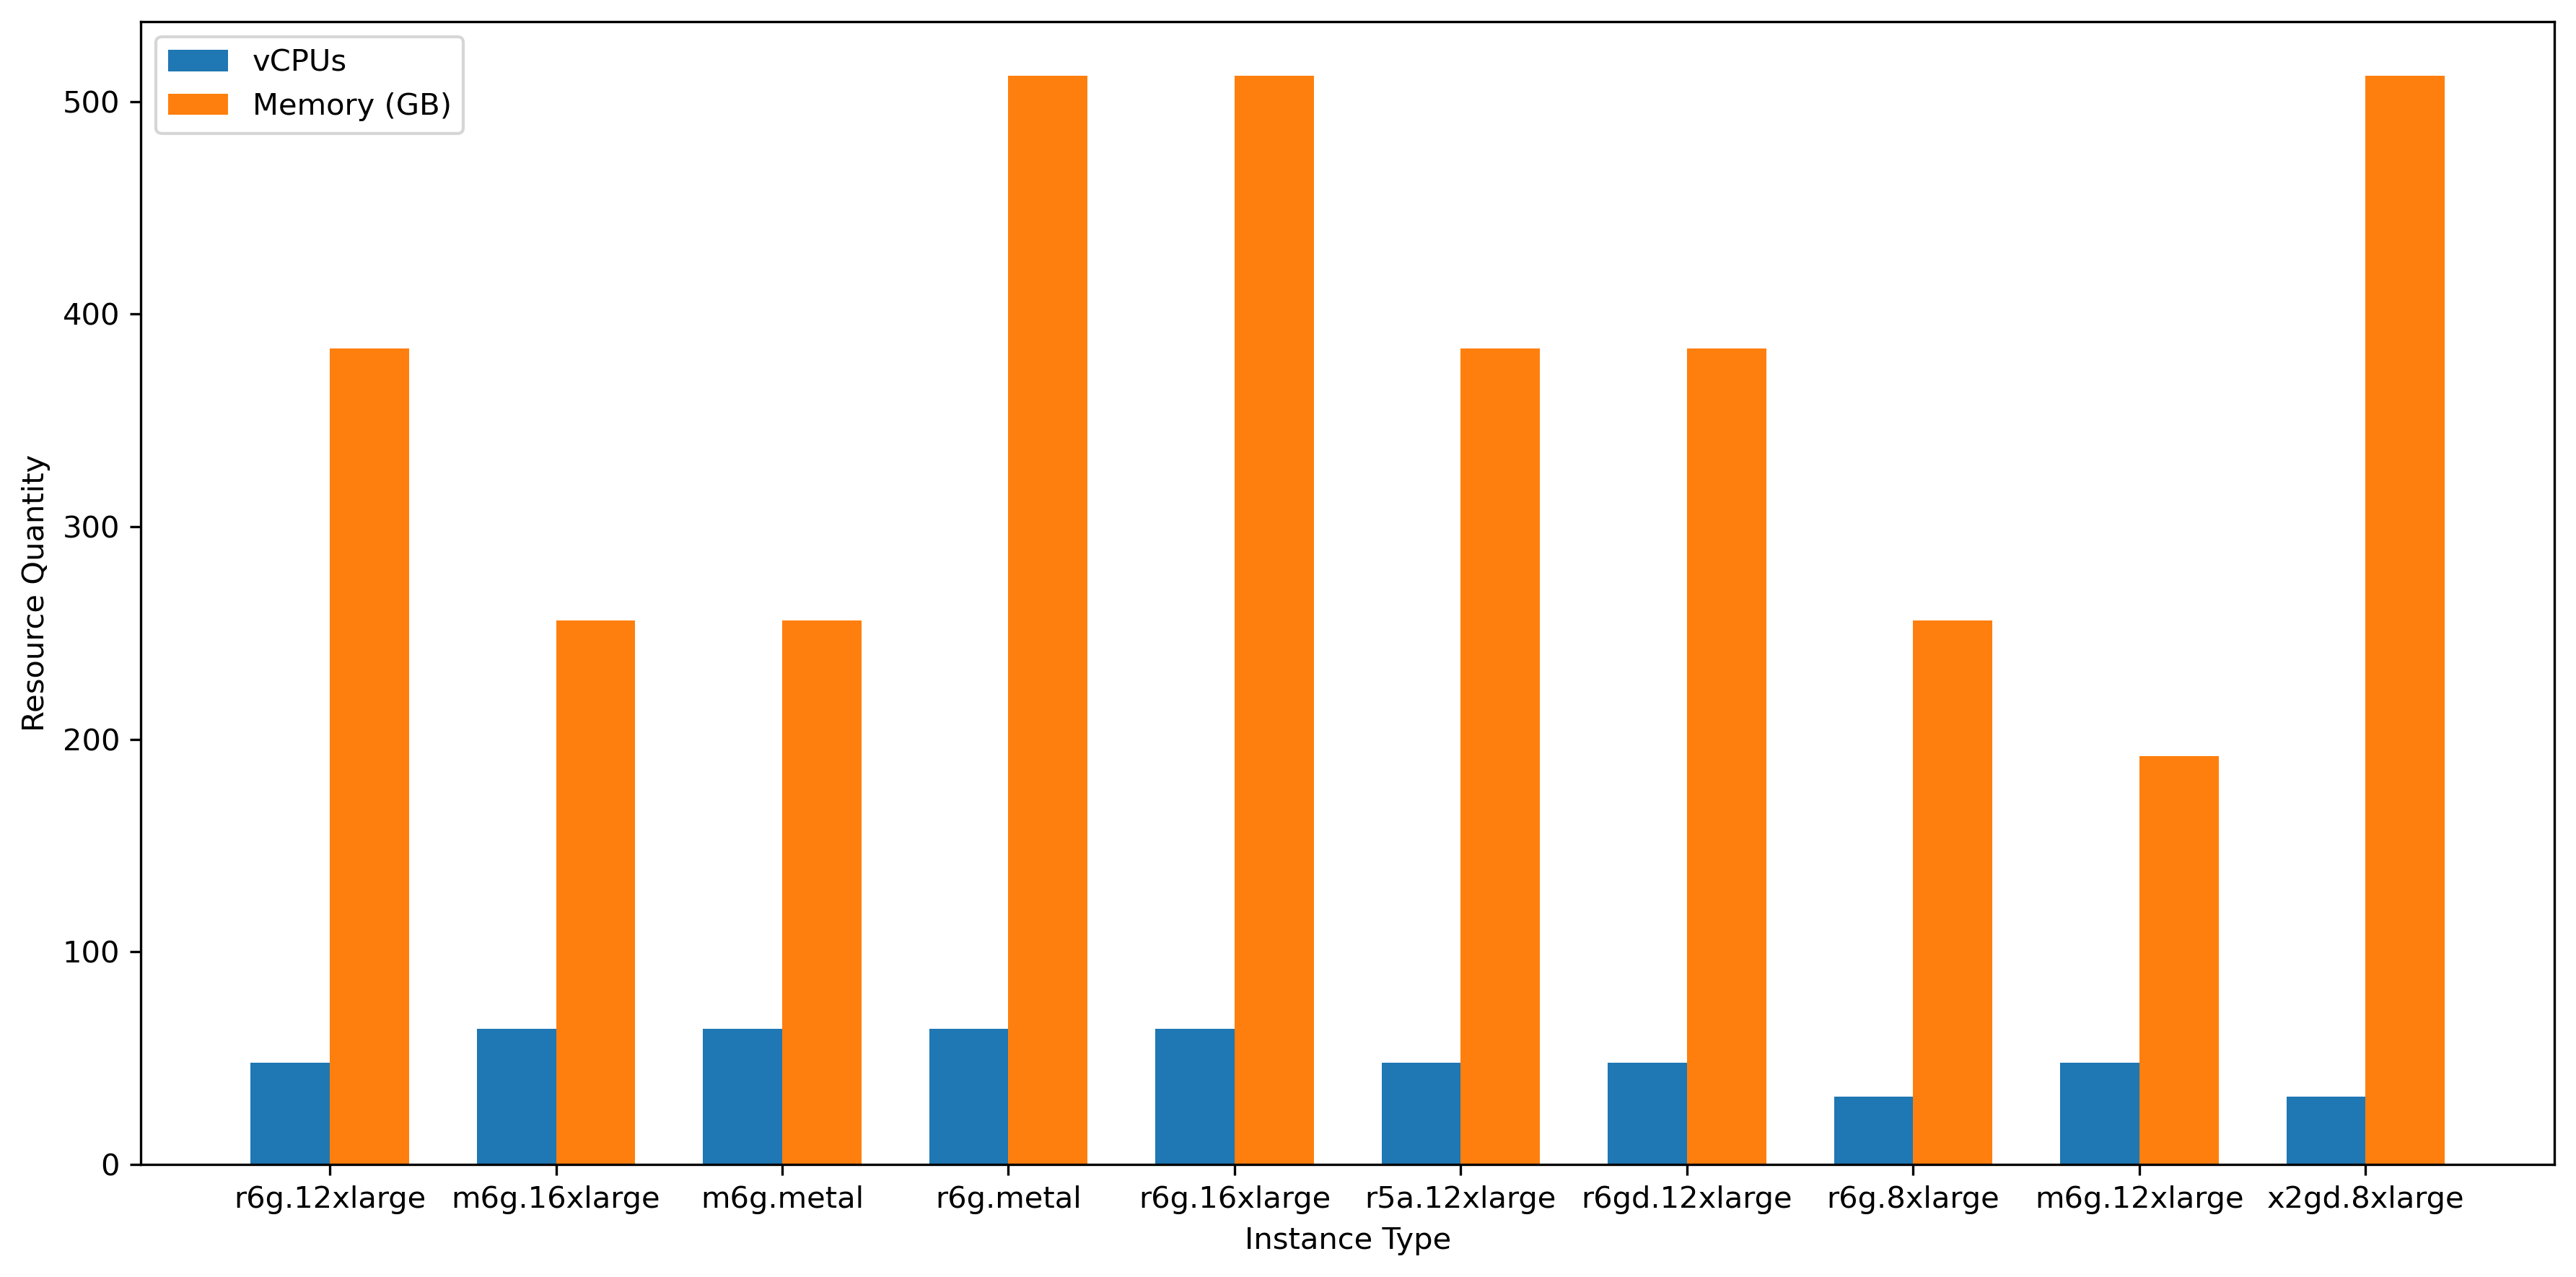

In [35]:
bar_width = 0.35

index = np.arange(len(instances_df))
fig, ax = plt.subplots(figsize=(12, 6), dpi=300)
vcpu_bars = ax.bar(index, instances_df['vCPUs'], bar_width, label='vCPUs')
memory_bars = ax.bar(index + bar_width, instances_df['Memory (GB)'], bar_width, label='Memory (GB)')

ax.set_xlabel('Instance Type')
ax.set_ylabel('Resource Quantity')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(instances_df['Instance Type'])
ax.legend()

plt.tight_layout()
# plt.savefig("vcpu_memory3.eps", dpi=300, bbox_inches='tight')
plt.show()

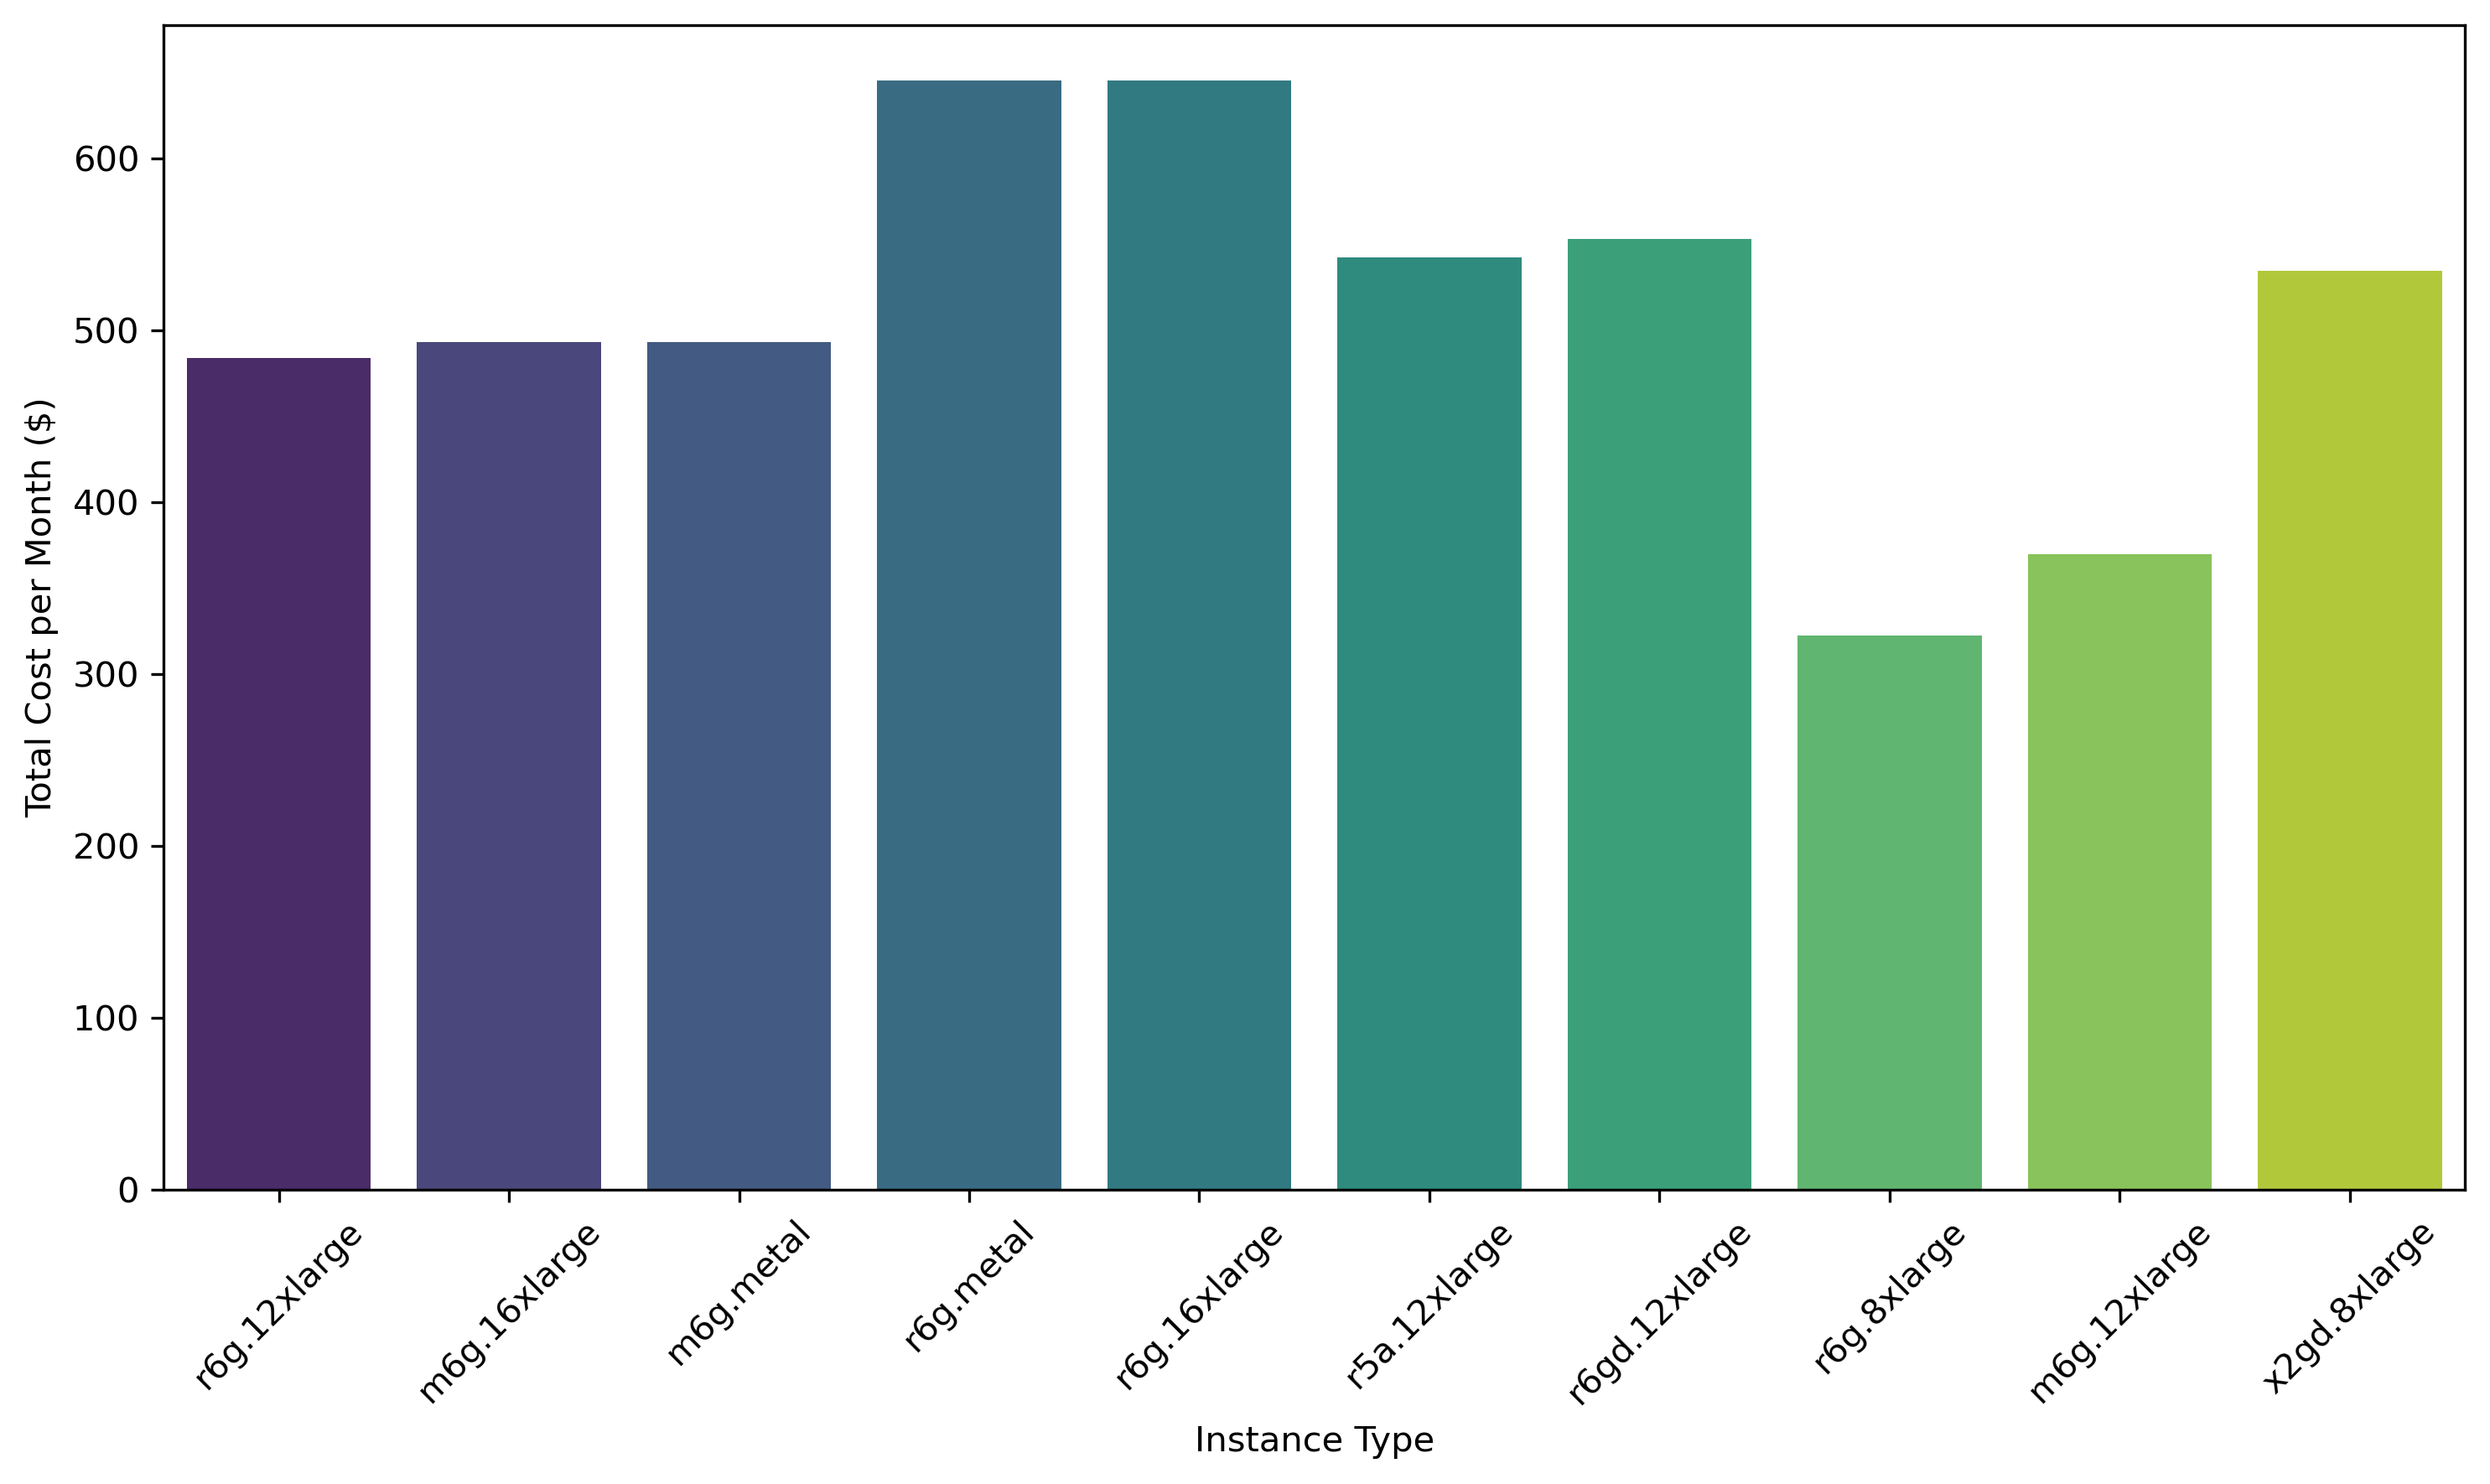

In [36]:
plt.figure(figsize=(10, 6), dpi=300)
sns.barplot(data=instances_df, x='Instance Type', y='Total Bill Per Month ($)', palette='viridis')

plt.xlabel('Instance Type')
plt.ylabel('Total Cost per Month ($)')
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig("total_cost3.eps", dpi=300, bbox_inches='tight')
plt.show()

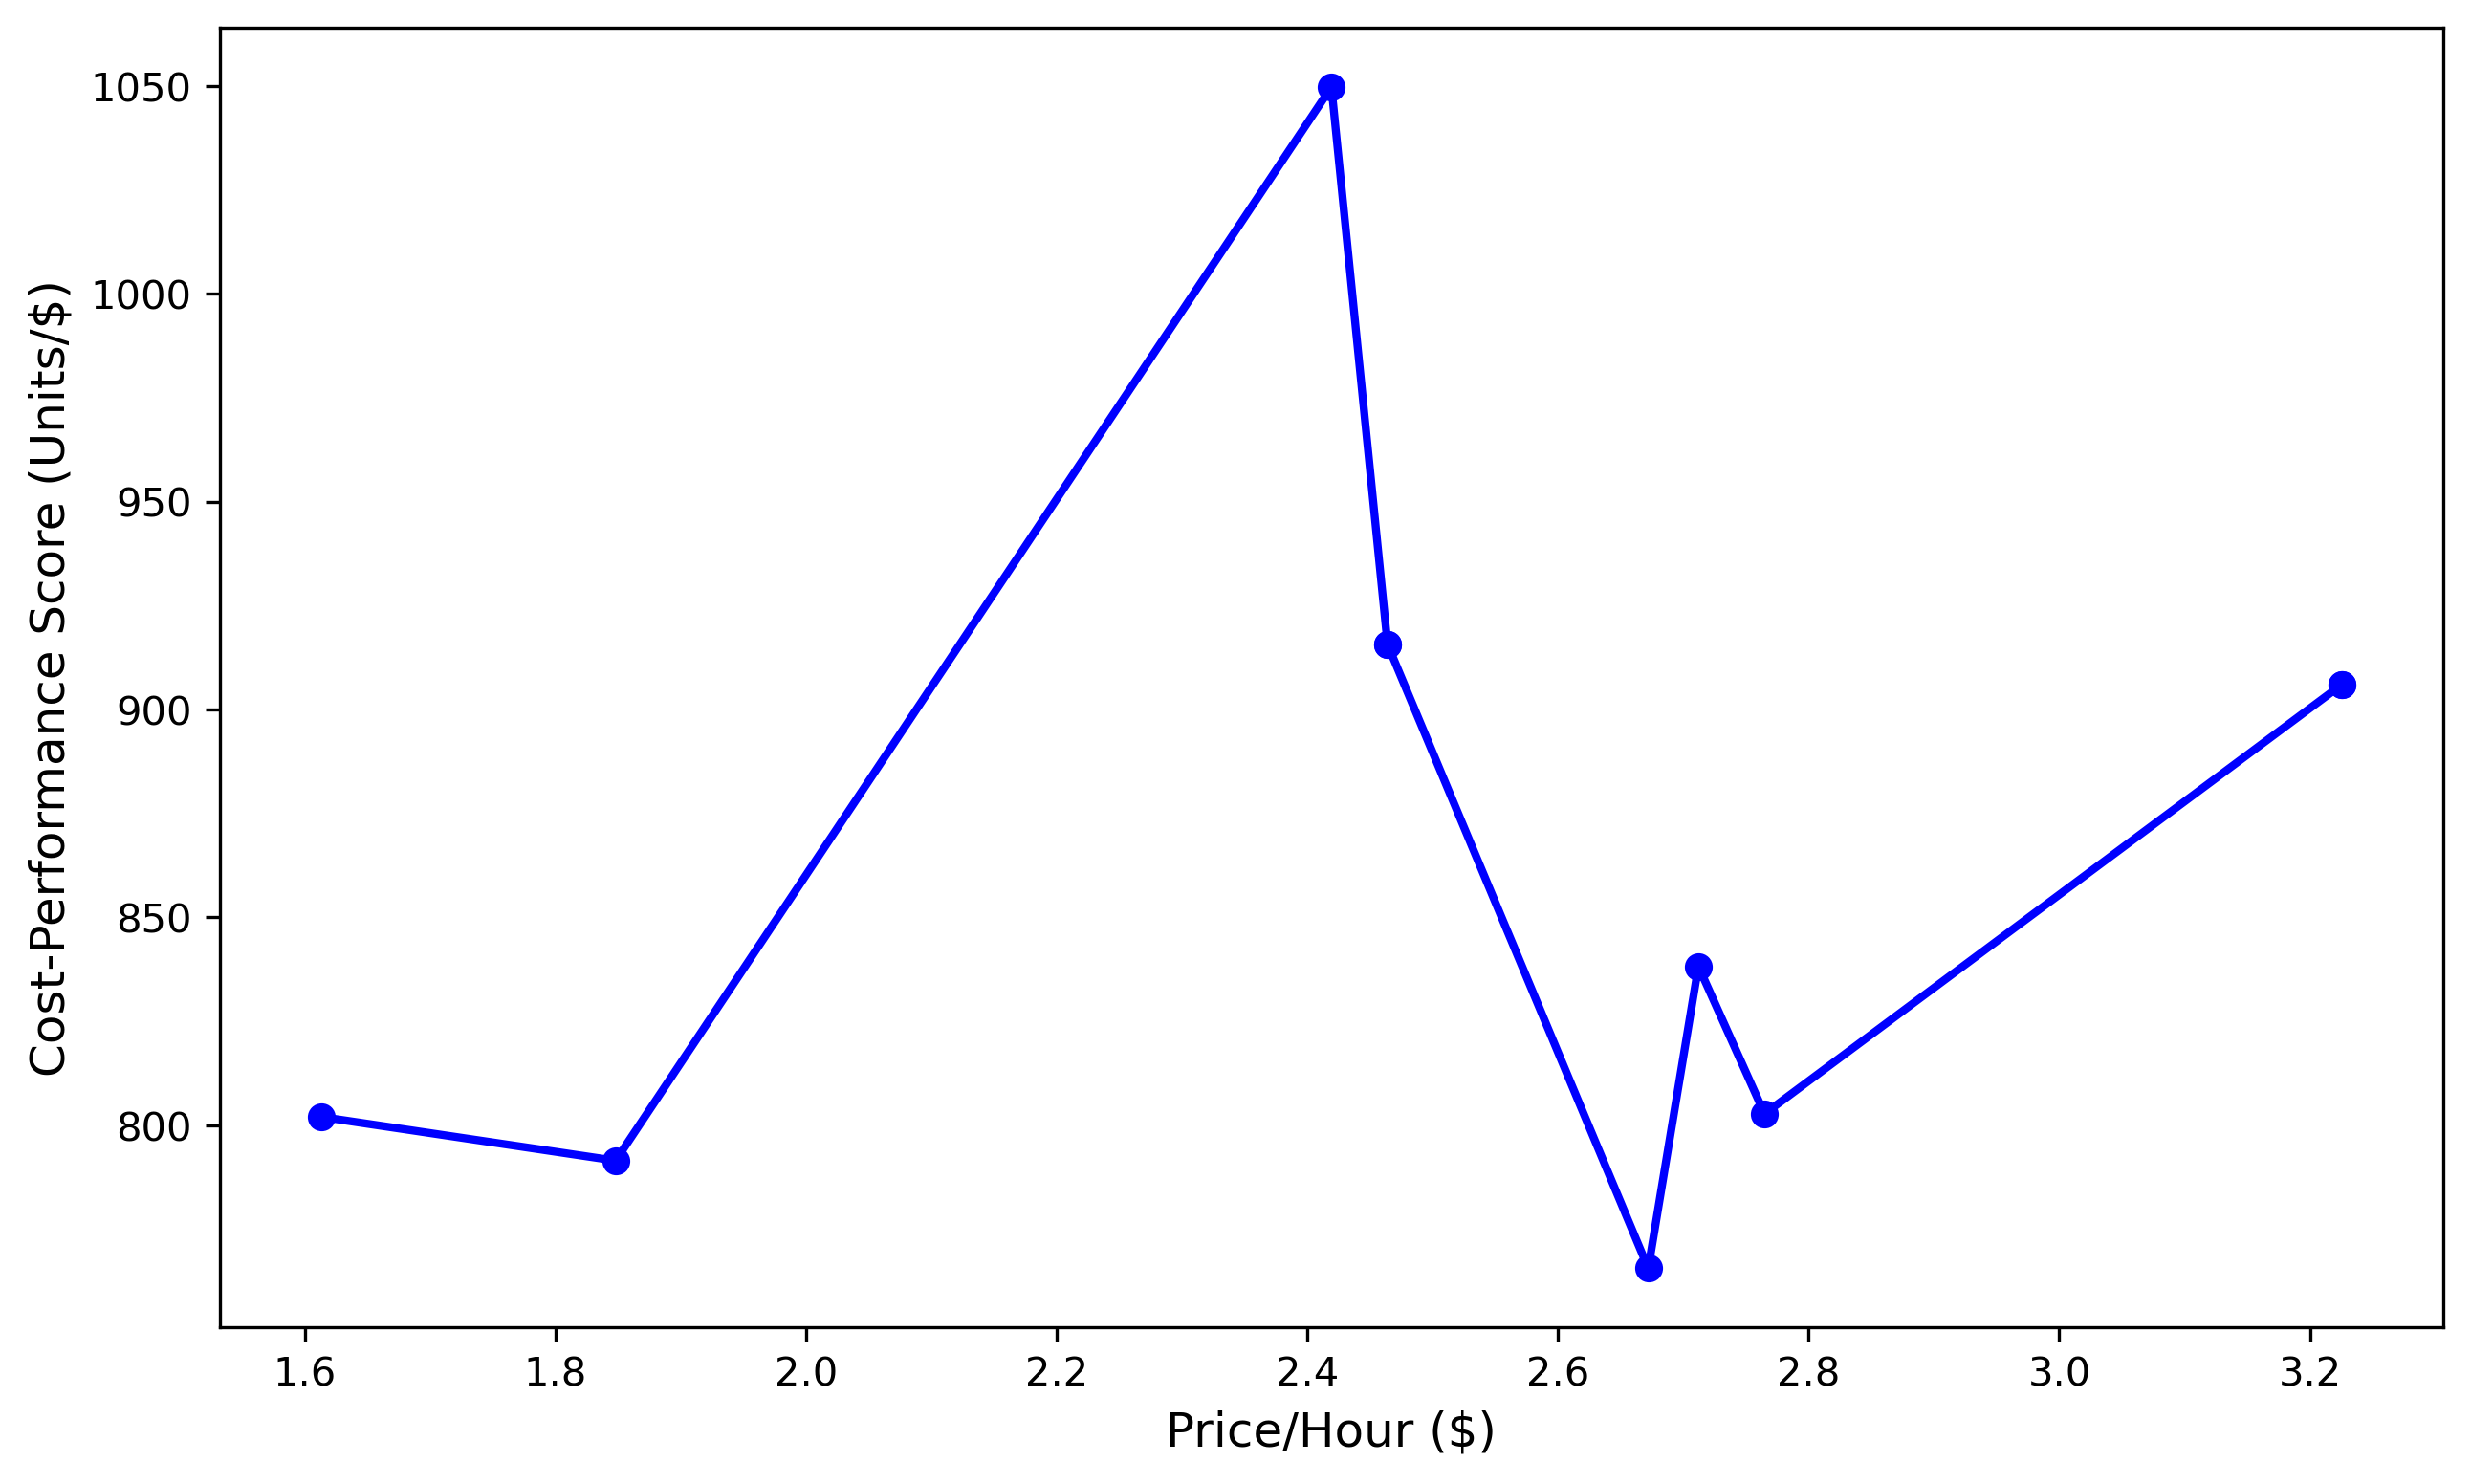

In [37]:
instances_df_sorted = instances_df.sort_values(by="Price/Hour ($)")

# Create a line plot for Cost vs. Performance
plt.figure(figsize=(10, 6), dpi=300)  # High resolution
plt.plot(instances_df_sorted["Price/Hour ($)"], instances_df_sorted["Cost-Performance Score"], color="b", marker="o", linestyle='-', linewidth=2)

# Adding labels and title
plt.xlabel("Price/Hour ($)", fontsize=12)
plt.ylabel("Cost-Performance Score (Units/$)", fontsize=12)


# Save the figure
# plt.savefig("cost_vs_performance_trend3.eps", dpi=300, bbox_inches='tight')
plt.show()